# PART I: Theory Questions

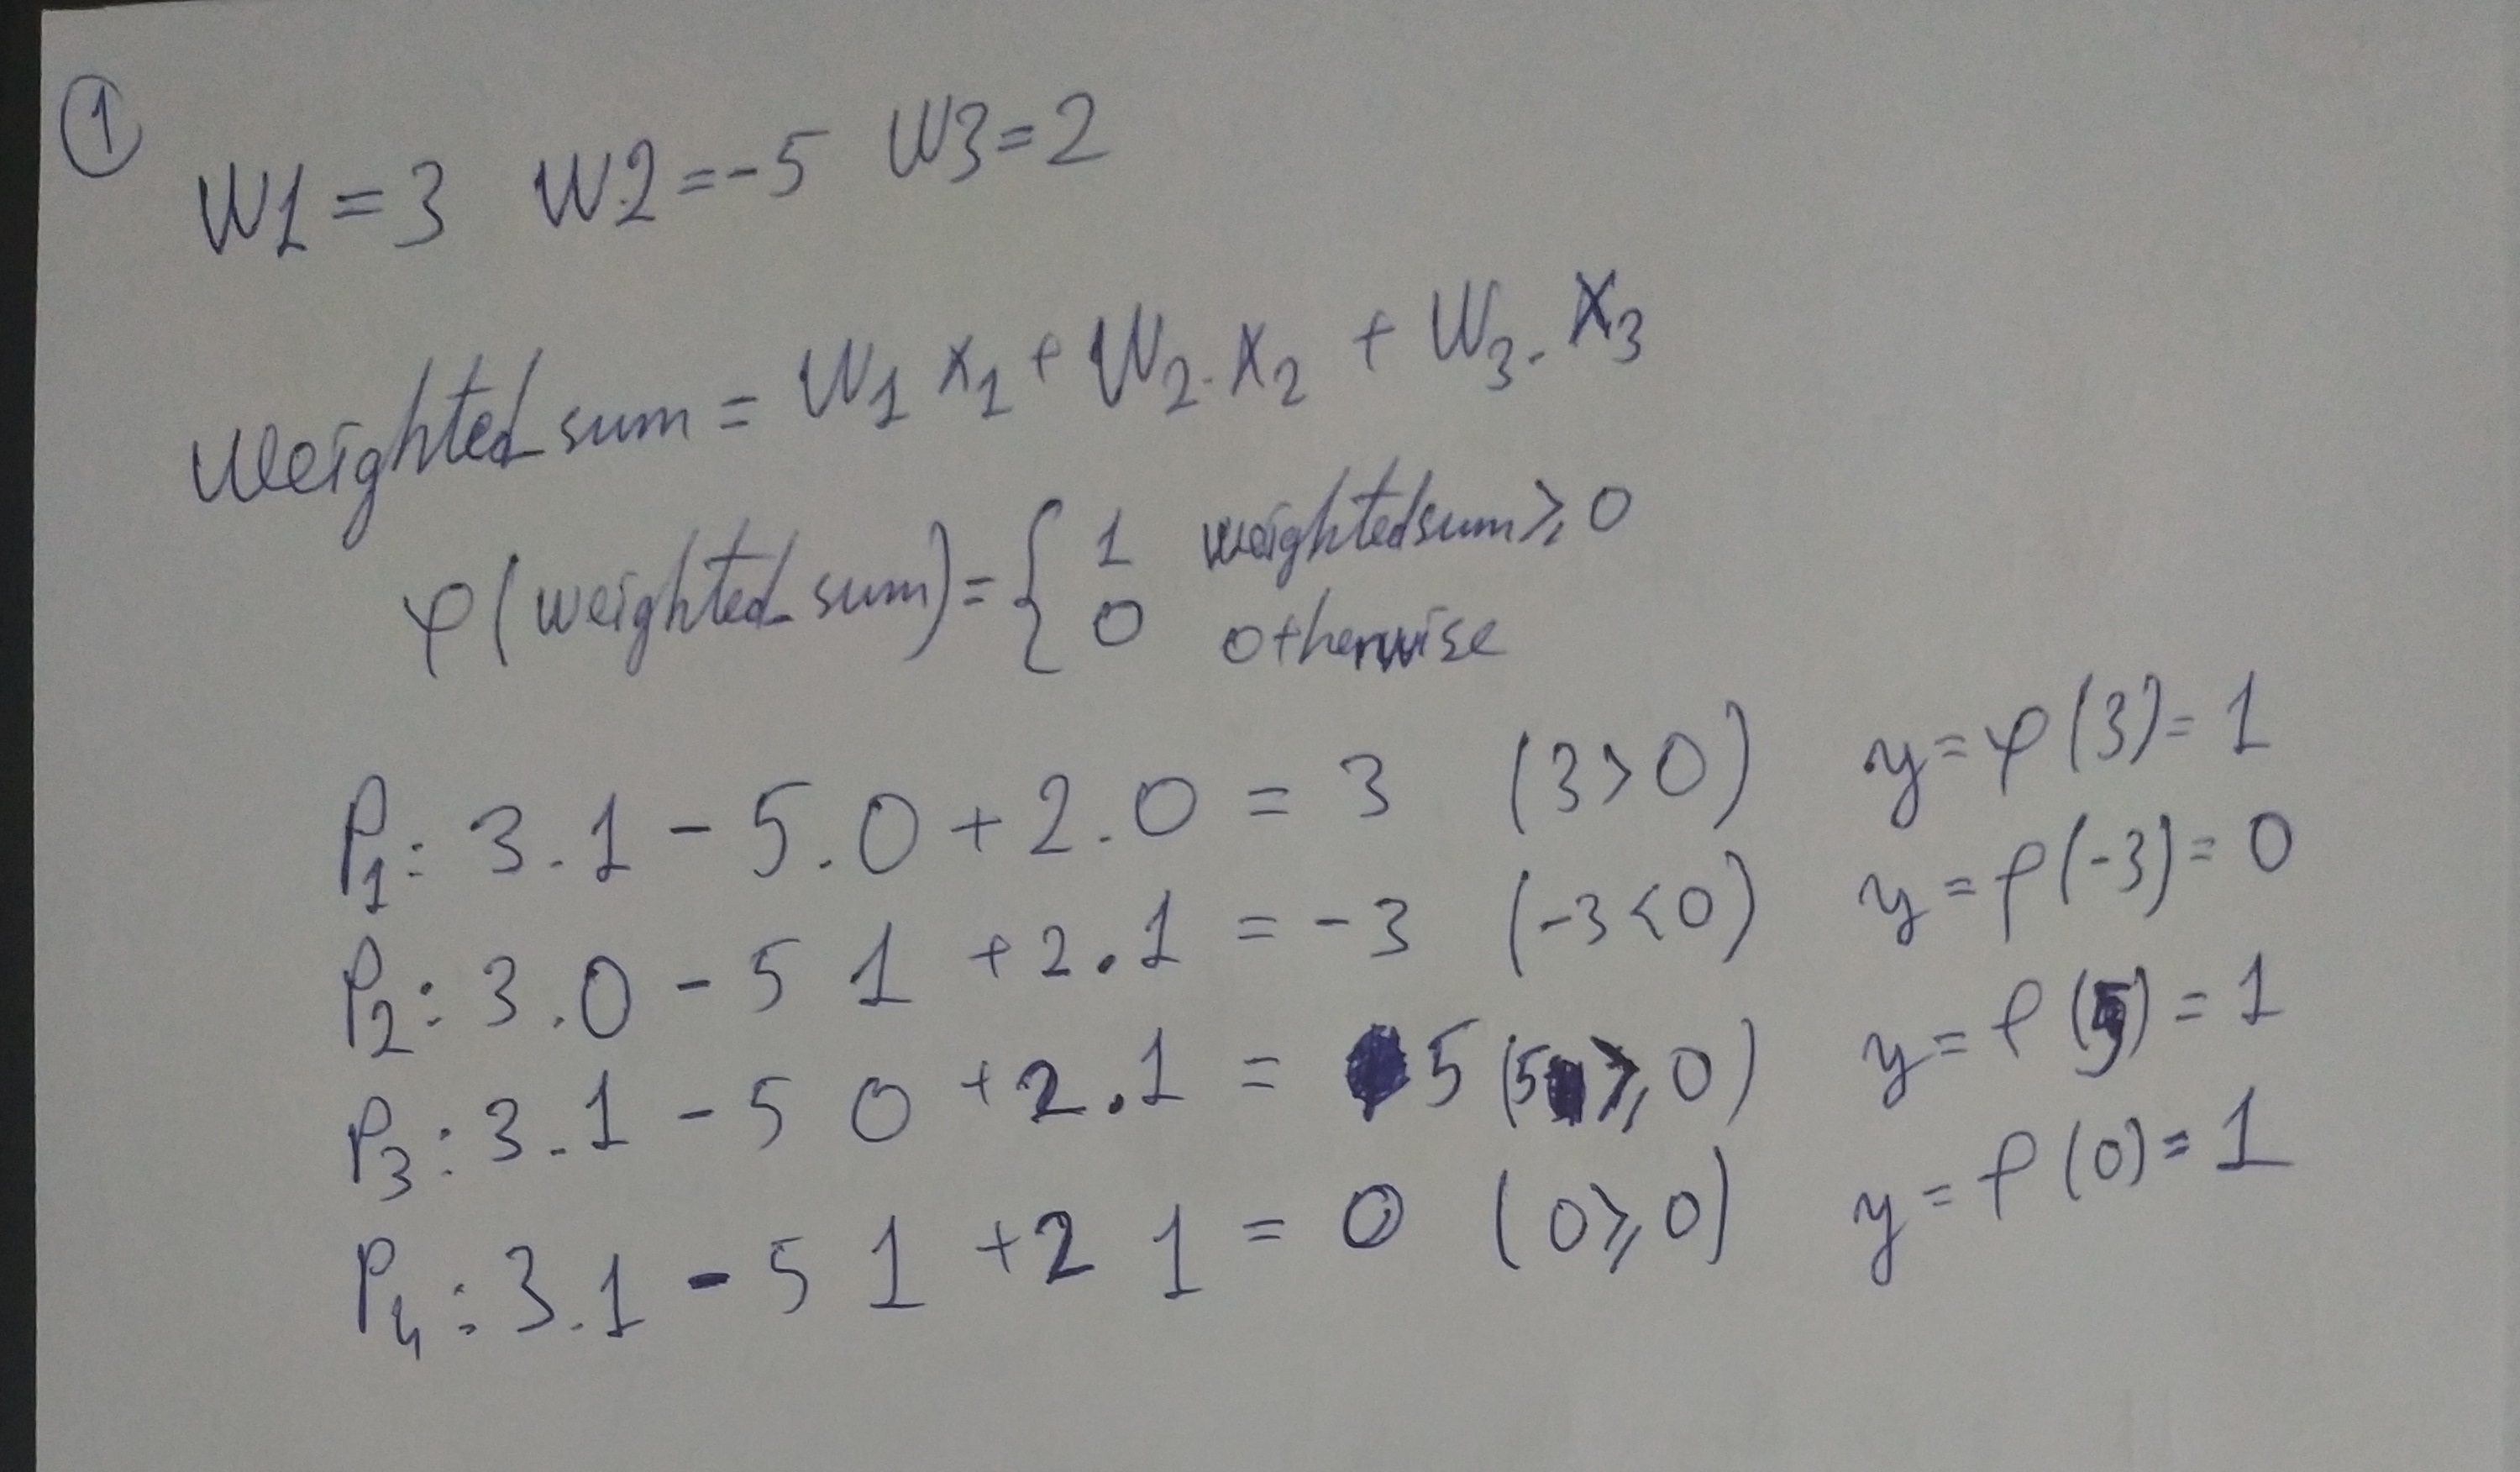

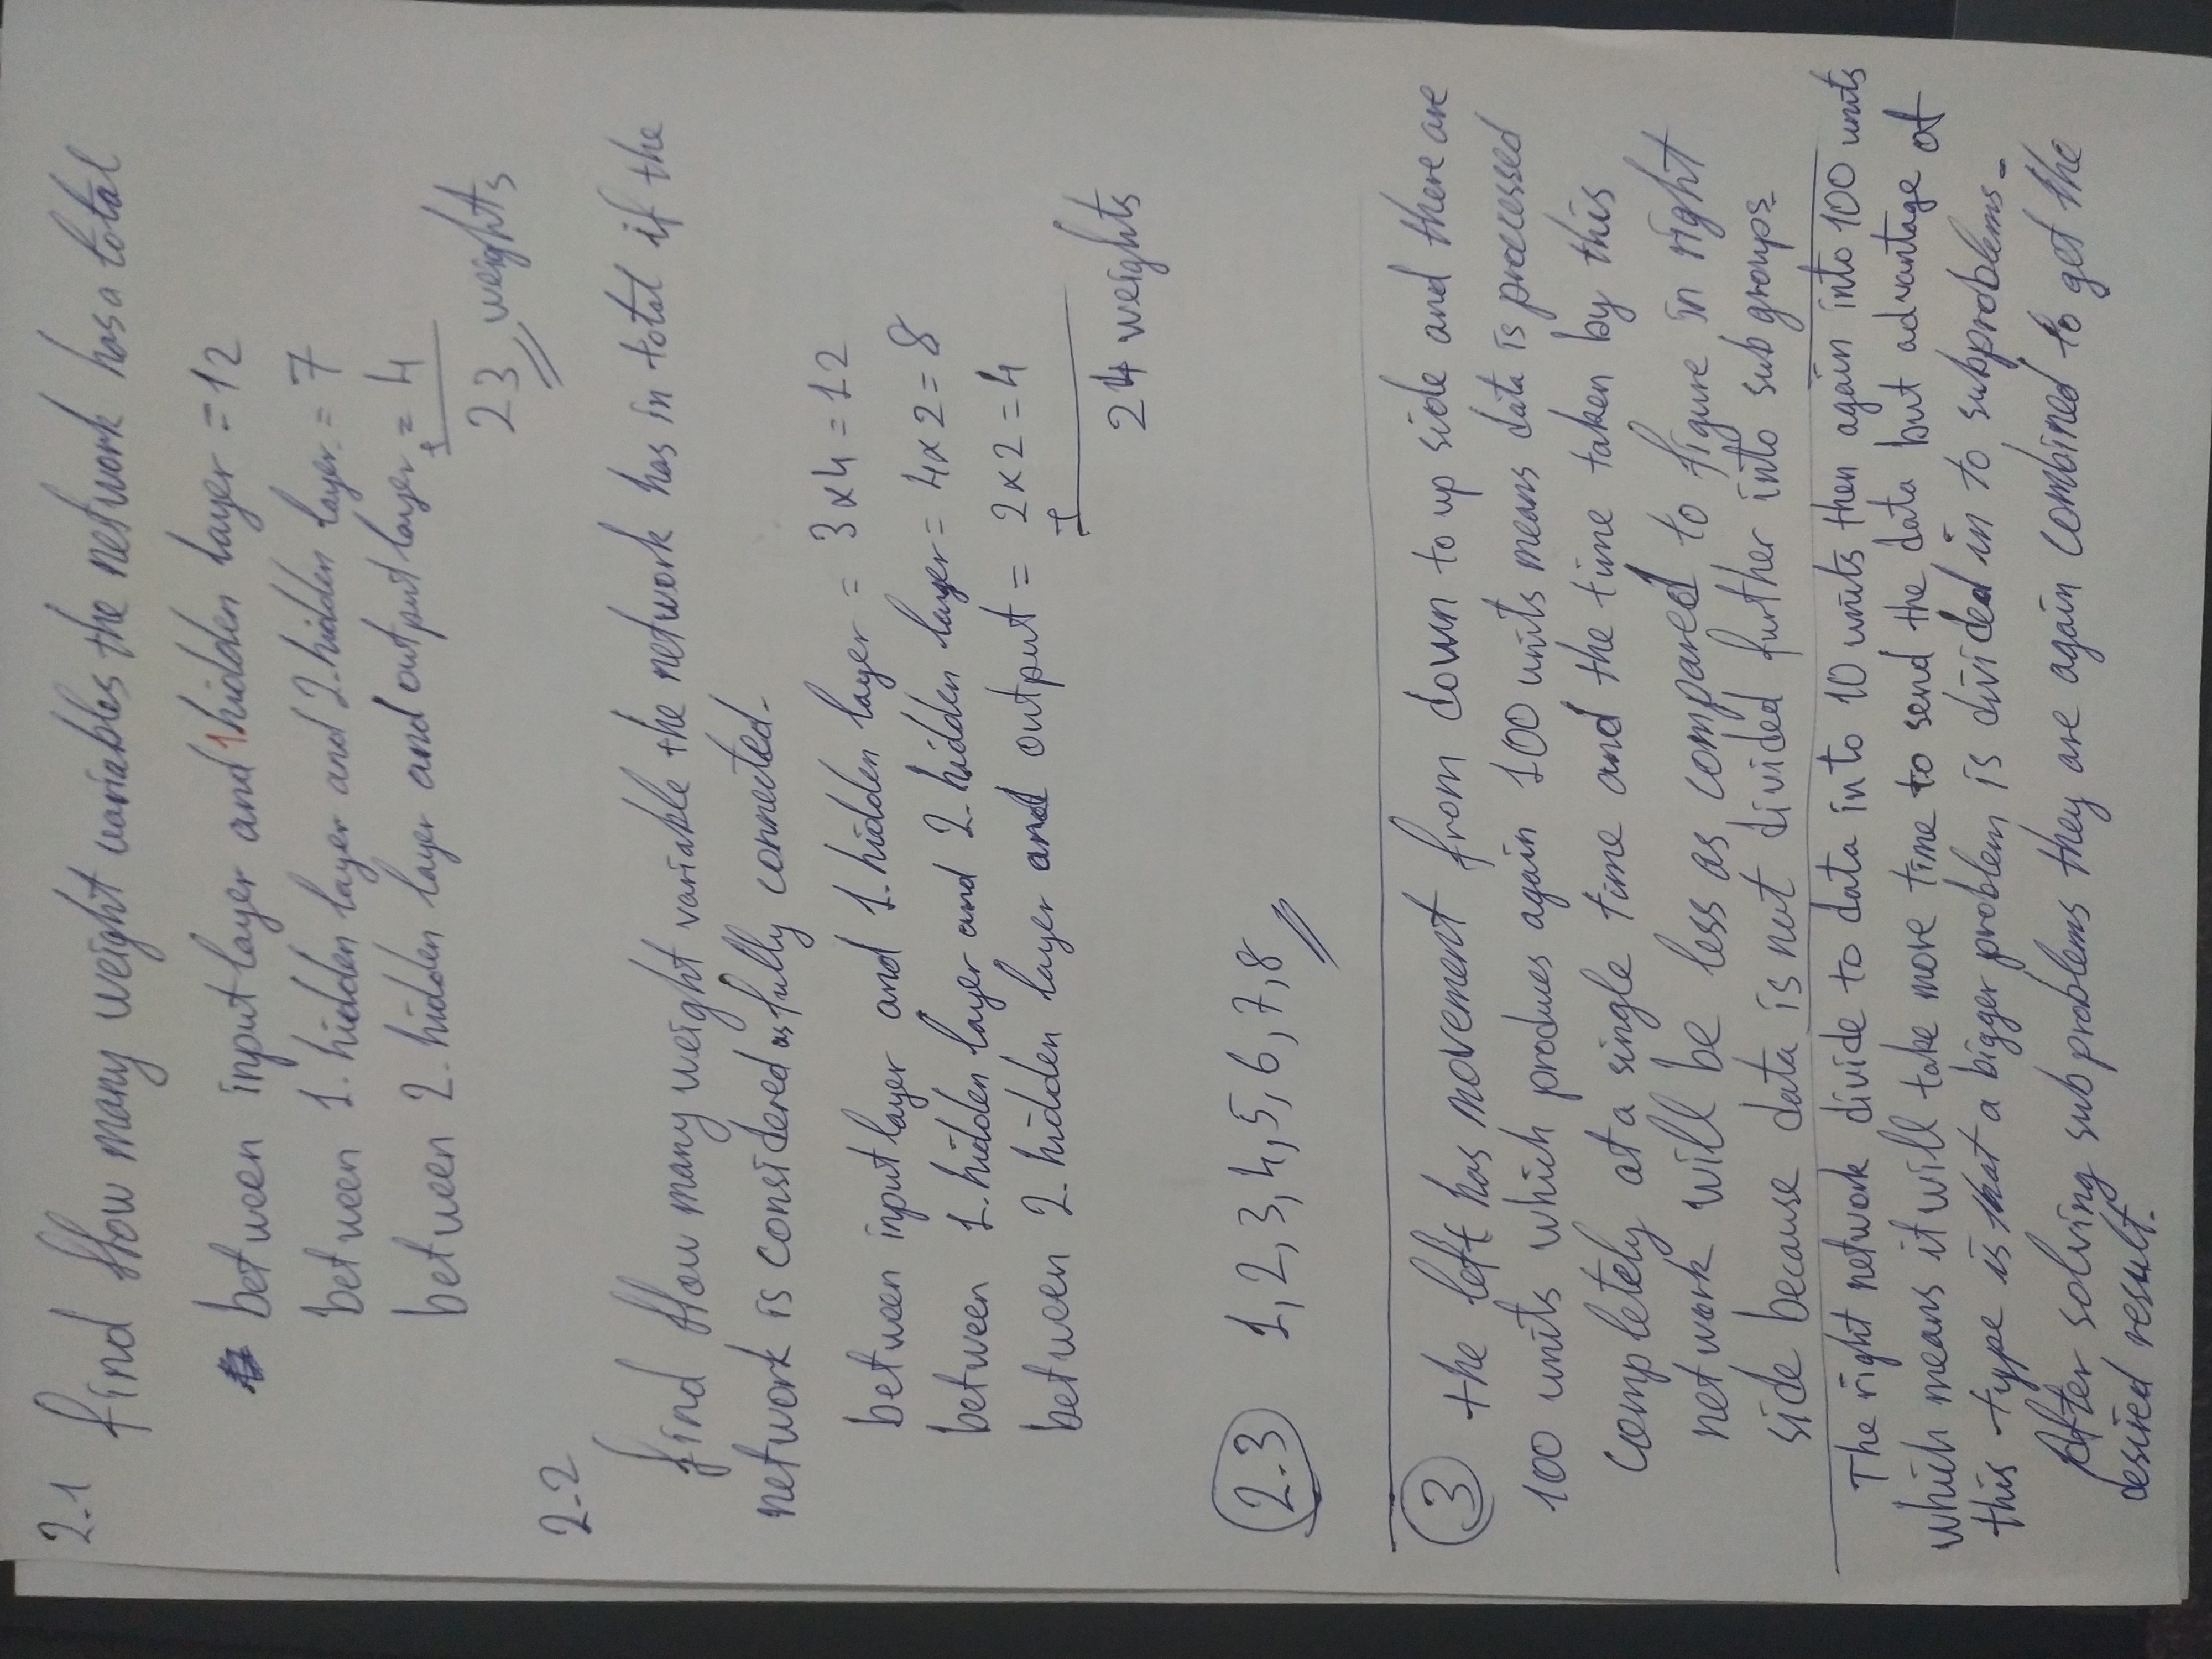

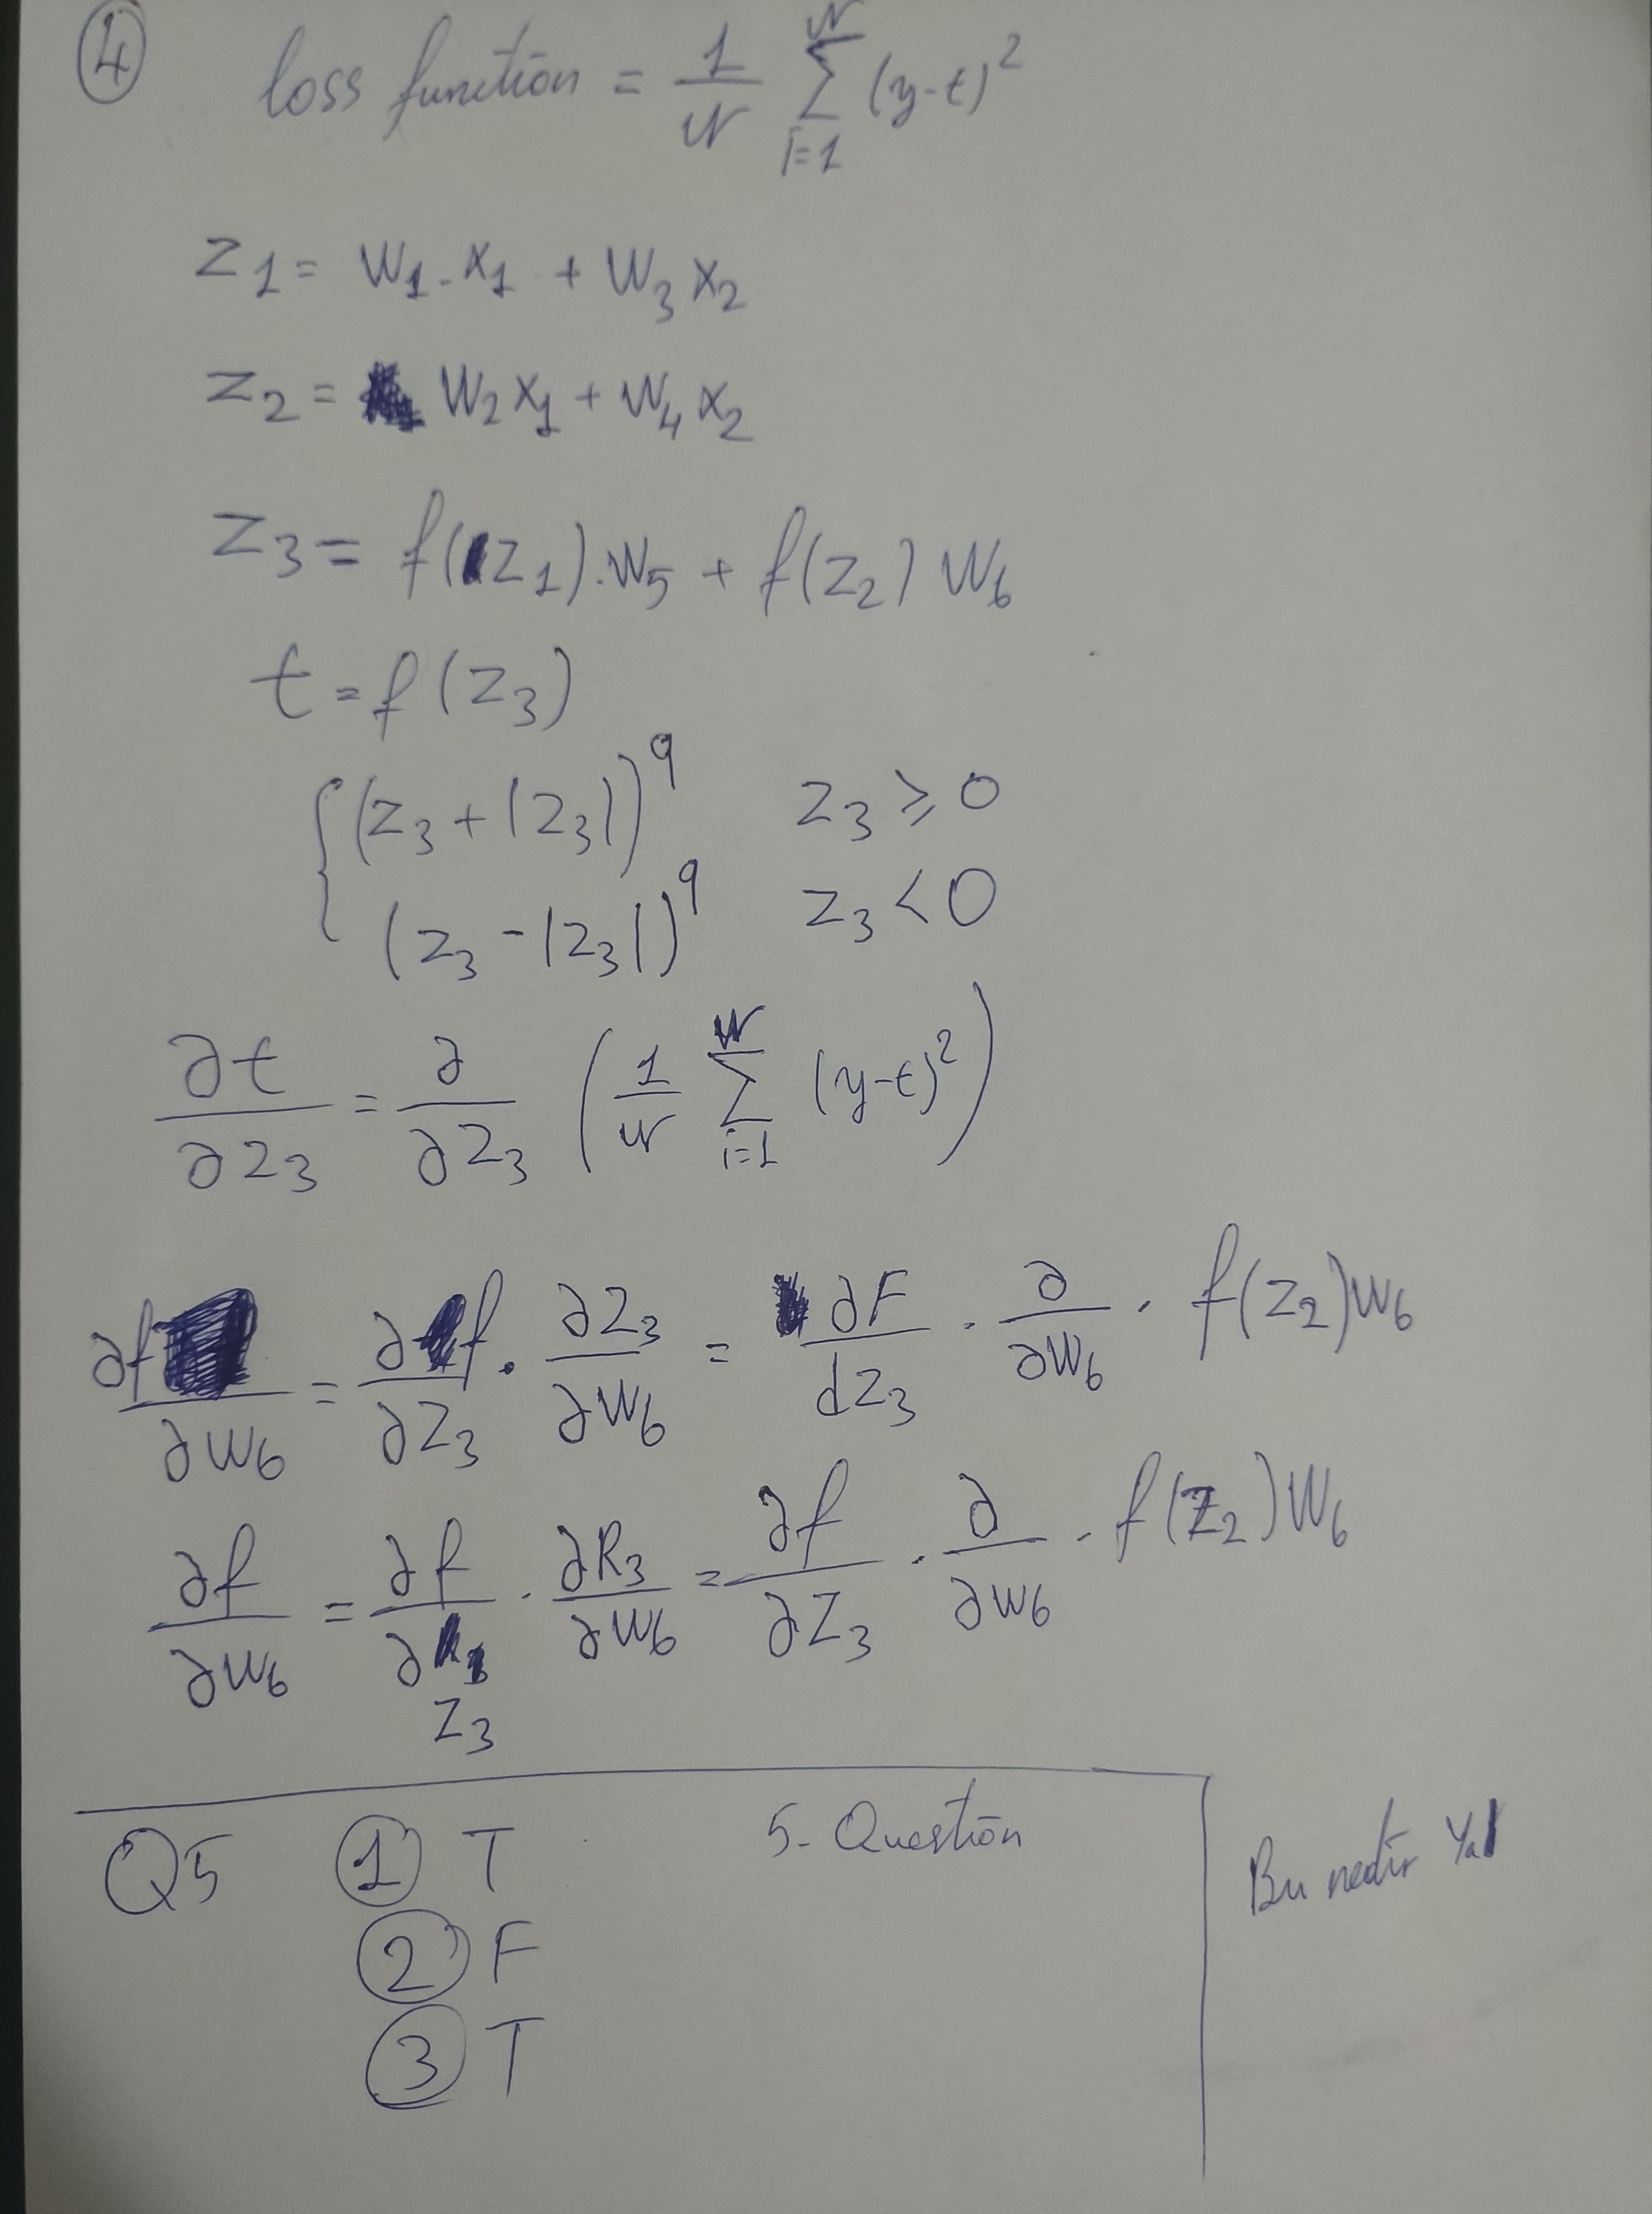

# PART II: Classication of Natural Scenes using Neural Network

## L-layer Neural Network

In [1]:
import numpy as np
import sys
import os
import ast
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


class CNN:
    def __init__(self, layer_dims=None, learning_rate=0.002, num_epoch=100, batch_size=16, layer_activation="relu",
                 last_layer_act_func="softmax"):
        if layer_dims is None:
            raise ImportError("You need enter layer dims Like [900,6] ")
        if len(layer_dims) < 2:
            raise ImportError("You must enter at least 2 layers ->1 input 1 output")
        self.layer_dims = layer_dims
        # setting dataset
        self.train_X = None
        self.train_Y = None
        self.test_X = None
        self.test_Y = None
        self.class_info = {}
        # hyper parameters
        self.learning_rate = learning_rate
        self.num_epoch = num_epoch
        self.batch_size = batch_size
        self.layer_activation = layer_activation
        self.last_layer_act_func = last_layer_act_func

    def read_train(self, path, modelname="train"):
        if not os.path.exists("models"):
            os.makedirs("models")
        onlydirectory = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

        train_X = []
        train_Y = []
        for i in range(len(onlydirectory)):
            print(path +"\\"+ onlydirectory[i])
            path_directory = path + "\\" + onlydirectory[i]
            files = os.listdir(path_directory)
            self.class_info[i] = onlydirectory[i]
            for image in files:
                # read image
                im = Image.open(path_directory + "\\" + image)
                # resize image
                im = im.resize((30, 30))
                # grey format
                im = im.convert('L')
                # PIL to numpy array
                data = np.asarray(im)
                # matrix to array
                data = data.flatten()
                data = np.divide(data, 255)
                train_X.append(data)
                train_Y.append(i)
        # save data to disk
        self.save(np.array(train_X, dtype=float), path=modelname + "_X")
        self.save(np.array(train_Y, dtype=int), path=modelname + "_Y")
        file1 = open("models/" + modelname + "class_info.txt", "w")
        file1.write(str(self.class_info))
        file1.close()
    # load data from disk
    def load_train(self, modelname="train"):

        if os.path.exists('models/' + modelname + "_X.npy"):
            if modelname == "train":
                self.train_X = self.load(path="models/" + modelname + "_X.npy")
                self.train_Y = self.load(path="models/" + modelname + "_Y.npy")
                randomize = np.arange(len(self.train_X))
                np.random.shuffle(randomize)
                self.train_X = self.train_X[randomize]
                self.train_Y = self.train_Y[randomize]
            elif modelname == "validation":
                self.test_X = self.load(path="models/" + modelname + "_X.npy")
                self.test_Y = self.load(path="models/" + modelname + "_Y.npy")
        else:
            raise FileNotFoundError("models/" + modelname + " not found")
    # numpy save function
    def save(self, arr, path="model"):
        if not os.path.exists("models"):
            os.makedirs("models")
        with open("models/" + path + ".npy", 'wb') as f:
            np.save(f, arr)
    # numpy load function
    def load(self, path="model.npy"):
        with open(path, 'rb') as f:
            return np.load(f, allow_pickle=True)
    # save weights
    def save_models(self):
        self.save(self.parameters)

    def relu(self, Z):
        return np.maximum(0, Z)
    # A sigmoid function is an activation function. 
    # For any given input number n, the sigmoid function maps that number to output between 0 and 1.
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def softmax(self, Z):
        return np.exp(Z) / np.sum(np.exp(Z))

    def tanh(self, Z):
        return np.tanh(Z)

    def derivative_sigmoid(self, X):
        sigmo = self.sigmoid(X)
        return sigmo * (1 - sigmo)

    def derivative_relu(self, Z):
        return np.greater(Z, 0).astype(int)
    # create random weight and 0 bias
    def init_parameter(self):
        self.parameters = {}
        len_of_layer = len(self.layer_dims)
        for i in range(1, len_of_layer):
            self.parameters['W' + str(i)] = np.random.randn(self.layer_dims[i], self.layer_dims[i - 1]) * 0.01
            self.parameters['b' + str(i)] = np.zeros((self.layer_dims[i], 1))
    
    def forward_activation(self, Z, activation):
        if activation == "sigmoid":
            return self.sigmoid(Z)
        elif activation == "relu":
            return self.relu(Z)
        elif activation == "softmax":
            return self.softmax(Z)
        elif activation == "tanh":
            return self.tanh(Z)
        else:
            raise ImportError("forward_activation function not found")

    def bacward_activation(self, Z):
        if self.layer_activation == "sigmoid":
            return self.derivative_sigmoid(Z)
        elif self.layer_activation == "relu":
            return self.derivative_relu(Z)
        elif self.layer_activation == "softmax":
            return self.softmax(Z)
        else:
            raise ImportError("bacward_activation function not found")

    def forward(self, X):
        layer_result = {}
        activation_result = {}
        # input vector -> A0 -> I need to save in activation_result (for loop)
        activation_result["A0"] = X
        len_of_layer = len(self.layer_dims)
        for i in range(1, len_of_layer - 1):
            layer_result["Z" + str(i)] = np.dot(self.parameters['W' + str(i)], activation_result['A' + str(i - 1)]) + self.parameters['b' + str(i)]
            activation_result["A" + str(i)] = self.forward_activation(layer_result["Z" + str(i)], self.layer_activation)

        # output -> softmax
        layer_result["Z" + str(len_of_layer - 1)] = np.dot(self.parameters['W' + str(len_of_layer - 1)],
                                                           activation_result["A" + str(len_of_layer - 2)]) + \
                                                    self.parameters['b' + str(len_of_layer - 1)]
        activation_result["A" + str(len_of_layer - 1)] = self.forward_activation(
            layer_result["Z" + str(len_of_layer - 1)], self.last_layer_act_func)

        return layer_result, activation_result
    # transformer
    def one_hot_encoding(self, Y):
        one_hot_Y = np.zeros((Y.size, self.layer_dims[-1]))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    
    # Averaging over a training set of m examples we then have:
    # sum of negative log-likelihood
    def compute_loss(self, train_Y, last_Activation):
        train_Y = self.one_hot_encoding(train_Y)
        L_sum = np.sum(np.multiply(train_Y, np.log(last_Activation)))
        m = train_Y.shape[1]
        L = -(1. / m) * L_sum

        return L
    # For backpropagation, we’ll need to know how L changes with respect to each component wj of w. 
    # That is, we must compute each ∂L/∂wj.
    def backward(self, layer_result, activation_result, Y):
        derivate_results = {}
        one_hot_Y = self.one_hot_encoding(Y)

        derivate_results["dZ" + str(len(self.layer_dims) - 1)] = activation_result[
                                                                     "A" + str(len(self.layer_dims) - 1)] - one_hot_Y
        derivate_results["dW" + str(len(self.layer_dims) - 1)] = (1 / self.batch_size) * np.dot(
            derivate_results["dZ" + str(len(self.layer_dims) - 1)],
            activation_result["A" + str(len(self.layer_dims) - 2)].T)
        derivate_results["db" + str(len(self.layer_dims) - 1)] = (1 / self.batch_size) * np.sum(
            derivate_results["dZ" + str(len(self.layer_dims) - 1)])

        for i in range(len(self.layer_dims) - 1, 1, -1):
            derivate_results["dZ" + str(i - 1)] = np.dot(self.parameters["W" + str(i)].T,
                                                         derivate_results["dZ" + str(i)]) * self.bacward_activation(
                layer_result["Z" + str(i - 1)])
            derivate_results["dW" + str(i - 1)] = (1 / self.batch_size) * np.dot(derivate_results["dZ" + str(i - 1)],
                                                                                 activation_result["A" + str(i - 2)].T)
            derivate_results["db" + str(i - 1)] = (1 / self.batch_size) * np.sum(derivate_results["dZ" + str(i - 1)])

        return derivate_results

    def update_parameters(self, derivative_results):
        for i in range(len(self.layer_dims) - 1):
            self.parameters["W" + str(i + 1)] = self.parameters["W" + str(i + 1)] - (
                        self.learning_rate * derivative_results["dW" + str(i + 1)])
            self.parameters["b" + str(i + 1)] = self.parameters["b" + str(i + 1)] - (
                        self.learning_rate * derivative_results["db" + str(i + 1)])

    def get_predictions(self, A2):
        return np.argmax(A2, 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size

    def train(self):
        loss_list = []
        accuracy_list = []
        for i in tqdm(range(self.num_epoch)):
            # batch splitter
            total_loss = 0
            for j in range(self.train_X.shape[0] // self.batch_size):
                begin = j * self.batch_size
                end = begin + self.batch_size
                # Calculating the predicted output Y
                layer_result, activation_result = self.forward(self.train_X.T[:, begin:end])
                # error back
                derivate_results = self.backward(layer_result, activation_result, self.train_Y[begin:end])
                # Updating the weights and biases
                self.update_parameters(derivate_results)

                # forward all data for loss

                total_loss += self.compute_loss(self.train_Y[begin:end], activation_result["A" + str(len(activation_result) - 1)])

            loss_list.append(total_loss)

            test_layer_result, test_activation_result = self.forward(self.test_X.T)
            print("\nIteration: ", i + 1, "Total Loss: ", total_loss)
            predictions = self.get_predictions(test_activation_result["A" + str(len(self.layer_dims) - 1)])
            acc = self.get_accuracy(predictions, self.test_Y)
            print("Accuracy:", acc)
            accuracy_list.append(acc)

        plt.plot(loss_list, "b")
        plt.xlabel("Epochs")
        plt.ylabel('Loss')
        plt.show()

        plt.plot(accuracy_list, "r")
        plt.xlabel("Epochs")
        plt.ylabel('Accuracy')
        plt.show()


## Single Layer Neural Network

C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\buildings
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\forest
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\glacier
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\mountain
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\sea
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\street
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\buildings
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\forest
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\glacier
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\mountain
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\sea
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\street


  1%|          | 3/300 [00:00<00:10, 27.27it/s]


Iteration:  1 Total Loss:  358.5462888592585
Accuracy: 0.3393333333333333

Iteration:  2 Total Loss:  350.38336209691585
Accuracy: 0.346

Iteration:  3 Total Loss:  349.1482160993997
Accuracy: 0.35433333333333333

Iteration:  4 Total Loss:  348.96693232538433
Accuracy: 0.35333333333333333

Iteration:  5 Total Loss:  349.05679131677203
Accuracy: 0.3526666666666667

Iteration:  6 Total Loss:  349.2229382219773


  3%|▎         | 9/300 [00:00<00:10, 27.77it/s]

Accuracy: 0.3526666666666667

Iteration:  7 Total Loss:  349.3968828610235
Accuracy: 0.3526666666666667

Iteration:  8 Total Loss:  349.5499367918209
Accuracy: 0.35233333333333333

Iteration:  9 Total Loss:  349.6701350742131
Accuracy: 0.35033333333333333

Iteration:  10 Total Loss:  349.75377564419364
Accuracy: 0.351

Iteration:  11 Total Loss:  349.8014573609861
Accuracy: 0.3516666666666667

Iteration:  12 Total Loss:  349.8159535143274


  5%|▌         | 15/300 [00:00<00:10, 27.91it/s]

Accuracy: 0.3526666666666667

Iteration:  13 Total Loss:  349.80100670361594
Accuracy: 0.353

Iteration:  14 Total Loss:  349.76064176898205
Accuracy: 0.356

Iteration:  15 Total Loss:  349.69878467890976
Accuracy: 0.35633333333333334

Iteration:  16 Total Loss:  349.61906475303175
Accuracy: 0.35733333333333334

Iteration:  

  7%|▋         | 21/300 [00:00<00:10, 27.74it/s]

17 Total Loss:  349.52472618563206
Accuracy: 0.357

Iteration:  18 Total Loss:  349.41860341551404
Accuracy: 0.3566666666666667

Iteration:  19 Total Loss:  349.3031323547062
Accuracy: 0.3576666666666667

Iteration:  20 Total Loss:  349.18038034663823
Accuracy: 0.35833333333333334

Iteration:  21 Total Loss:  349.0520845171999
Accuracy: 0.3586666666666667

Iteration:  22 Total Loss:  348.9196924320848


  8%|▊         | 24/300 [00:00<00:10, 27.59it/s]

Accuracy: 0.359

Iteration:  23 Total Loss:  348.78440162073474
Accuracy: 0.359

Iteration:  24 Total Loss:  348.6471961602097
Accuracy: 0.36033333333333334

Iteration:  25 Total Loss:  348.5088795040411
Accuracy: 0.35933333333333334

Iteration:  26 Total Loss:  348.37010332853185
Accuracy: 0.35933333333333334

Iteration:  27 Total Loss:  348.23139250282514
Accuracy: 0.35933333333333334


 10%|█         | 31/300 [00:01<00:09, 28.63it/s]


Iteration:  28 Total Loss:  348.09316646573023
Accuracy: 0.35933333333333334

Iteration:  29 Total Loss:  347.95575737284594
Accuracy: 0.35933333333333334

Iteration:  30 Total Loss:  347.8194254009233
Accuracy: 0.359

Iteration:  31 Total Loss:  347.6843715870634
Accuracy: 0.35933333333333334

Iteration:  32 Total Loss:  347.5507485535401
Accuracy: 0.3596666666666667

Iteration:  33 Total Loss:  347.4186694341403
Accuracy: 0.36033333333333334

Iteration:  34 Total Loss:  347.2882152805554


 12%|█▏        | 37/300 [00:01<00:09, 28.48it/s]

Accuracy: 0.3596666666666667

Iteration:  35 Total Loss:  347.15944119073697
Accuracy: 0.3606666666666667

Iteration:  36 Total Loss:  347.03238136702544
Accuracy: 0.361

Iteration:  37 Total Loss:  346.9070532810836
Accuracy: 0.3626666666666667

Iteration:  38 Total Loss:  346.78346109546425
Accuracy: 0.36233333333333334

Iteration:  39 Total Loss:  346.66159846799246
Accuracy: 0.36233333333333334


 14%|█▍        | 43/300 [00:01<00:09, 28.49it/s]


Iteration:  40 Total Loss:  346.54145084479154
Accuracy: 0.3626666666666667

Iteration:  41 Total Loss:  346.42299733043126
Accuracy: 0.3616666666666667

Iteration:  42 Total Loss:  346.3062122089512
Accuracy: 0.362

Iteration:  43 Total Loss:  346.19106617713777
Accuracy: 0.36133333333333334

Iteration:  44 Total Loss:  346.07752734098966
Accuracy: 0.361

Iteration:  45 Total Loss:  345.9655620176207
Accuracy: 0.3606666666666667

Iteration:  46 Total Loss:  345.8551353775467

 16%|█▋        | 49/300 [00:01<00:08, 28.80it/s]


Accuracy: 0.3606666666666667

Iteration:  47 Total Loss:  345.7462119562686
Accuracy: 0.361

Iteration:  48 Total Loss:  345.63875605900023
Accuracy: 0.36133333333333334

Iteration:  49 Total Loss:  345.5327320782312
Accuracy: 0.3616666666666667

Iteration:  50 Total Loss:  345.42810474033007
Accuracy: 0.3616666666666667

Iteration:  51 Total Loss:  345.3248392945237
Accuracy: 0.361


 18%|█▊        | 55/300 [00:01<00:09, 26.31it/s]


Iteration:  52 Total Loss:  345.2229016552293
Accuracy: 0.36133333333333334

Iteration:  53 Total Loss:  345.1222585067258
Accuracy: 0.3606666666666667

Iteration:  54 Total Loss:  345.0228773775575
Accuracy: 0.36133333333333334

Iteration:  55 Total Loss:  344.9247266907027
Accuracy: 0.36033333333333334

Iteration:  56 Total Loss:  344.8277757944519


 19%|█▉        | 58/300 [00:02<00:09, 24.99it/s]

Accuracy: 0.36

Iteration:  57 Total Loss:  344.73199497802943
Accuracy: 0.36

Iteration:  58 Total Loss:  344.63735547523413
Accuracy: 0.3606666666666667

Iteration:  59 Total Loss:  344.54382945877916
Accuracy: 0.361

Iteration:  60 Total Loss:  344.4513900274886
Accuracy: 0.3606666666666667

Iteration:  61 Total Loss:  344.36001118810117


 21%|██▏       | 64/300 [00:02<00:09, 25.79it/s]

Accuracy: 0.3606666666666667

Iteration:  62 Total Loss:  344.26966783309643
Accuracy: 0.36033333333333334

Iteration:  63 Total Loss:  344.18033571566866
Accuracy: 0.36033333333333334

Iteration:  64 Total Loss:  344.09199142275935
Accuracy: 0.3606666666666667

Iteration:  65 Total Loss:  344.0046123468632
Accuracy: 0.3606666666666667

Iteration:  66 Total Loss:  343.9181766571771


 23%|██▎       | 70/300 [00:02<00:09, 25.19it/s]

Accuracy: 0.3606666666666667

Iteration:  67 Total Loss:  343.8326632705391
Accuracy: 0.3616666666666667

Iteration:  68 Total Loss:  343.7480518224958
Accuracy: 0.36233333333333334

Iteration:  69 Total Loss:  343.6643226387672
Accuracy: 0.36133333333333334

Iteration:  70 Total Loss:  343.58145670730744
Accuracy: 0.3616666666666667

Iteration:  71 Total Loss:  343.4994356511043


 25%|██▌       | 76/300 [00:02<00:08, 26.15it/s]

Accuracy: 0.36133333333333334

Iteration:  72 Total Loss:  343.41824170182434
Accuracy: 0.361

Iteration:  73 Total Loss:  343.337857674373
Accuracy: 0.36133333333333334

Iteration:  74 Total Loss:  343.25826694241283
Accuracy: 0.36033333333333334

Iteration:  75 Total Loss:  343.1794534148653
Accuracy: 0.36033333333333334

Iteration:  76 Total Loss:  343.1014015134003
Accuracy: 0.361


 26%|██▋       | 79/300 [00:02<00:08, 26.68it/s]


Iteration:  77 Total Loss:  343.02409615090914
Accuracy: 0.3616666666666667

Iteration:  78 Total Loss:  342.94752271094364
Accuracy: 0.3616666666666667

Iteration:  79 Total Loss:  342.8716670281014
Accuracy: 0.36233333333333334

Iteration:  80 Total Loss:  342.79651536932937
Accuracy: 0.3626666666666667

Iteration:  81 Total Loss:  342.722054416109
Accuracy: 0.3626666666666667

Iteration:  82 Total Loss:  342.64827124749667


 28%|██▊       | 85/300 [00:03<00:08, 26.03it/s]

Accuracy: 0.363

Iteration:  83 Total Loss:  342.5751533239801
Accuracy: 0.3626666666666667

Iteration:  84 Total Loss:  342.5026884721128
Accuracy: 0.36233333333333334

Iteration:  85 Total Loss:  342.43086486989654
Accuracy: 0.3626666666666667

Iteration:  86 Total Loss:  342.3596710328701
Accuracy: 0.362

Iteration:  87 Total Loss:  342.2890958008693


 30%|███       | 91/300 [00:03<00:08, 25.67it/s]

Accuracy: 0.362

Iteration:  88 Total Loss:  342.21912832543273
Accuracy: 0.362

Iteration:  89 Total Loss:  342.14975805780756
Accuracy: 0.36233333333333334

Iteration:  90 Total Loss:  342.08097473753594
Accuracy: 0.362

Iteration:  91 Total Loss:  342.0127683815789
Accuracy: 0.362

Iteration:  

 31%|███▏      | 94/300 [00:03<00:08, 24.95it/s]

92 Total Loss:  341.9451292739636
Accuracy: 0.36133333333333334

Iteration:  93 Total Loss:  341.8780479559108
Accuracy: 0.361

Iteration:  94 Total Loss:  341.81151521643096
Accuracy: 0.3616666666666667

Iteration:  95 Total Loss:  341.74552208335155
Accuracy: 0.362

Iteration:  96 Total Loss:  341.6800598147604
Accuracy: 0.36233333333333334

Iteration:  97 Total Loss:  341.6151198908395


 33%|███▎      | 100/300 [00:03<00:07, 26.34it/s]

Accuracy: 0.362

Iteration:  98 Total Loss:  341.5506940060684
Accuracy: 0.3616666666666667

Iteration:  99 Total Loss:  341.4867740617788
Accuracy: 0.3616666666666667

Iteration:  100 Total Loss:  341.4233521590391
Accuracy: 0.362

Iteration:  101 Total Loss:  341.3604205918537
Accuracy: 0.362

Iteration:  102 Total Loss:  341.29797184065995
Accuracy: 0.36233333333333334

Iteration:  103 Total Loss:  341.23599856610593


 35%|███▌      | 106/300 [00:03<00:06, 27.93it/s]

Accuracy: 0.36233333333333334

Iteration:  104 Total Loss:  341.174493603096
Accuracy: 0.36233333333333334

Iteration:  105 Total Loss:  341.1134499550881
Accuracy: 0.36233333333333334

Iteration:  106 Total Loss:  341.05286078863344
Accuracy: 0.36233333333333334

Iteration:  107 Total Loss:  340.99271942814124
Accuracy: 0.36233333333333334

Iteration:  108 Total Loss:  340.9330193508601
Accuracy: 0.3626666666666667


 37%|███▋      | 112/300 [00:04<00:06, 28.74it/s]


Iteration:  109 Total Loss:  340.87375418206983
Accuracy: 0.363

Iteration:  110 Total Loss:  340.81491769045755
Accuracy: 0.363

Iteration:  111 Total Loss:  340.756503783692
Accuracy: 0.3636666666666667

Iteration:  112 Total Loss:  340.69850650416305
Accuracy: 0.36333333333333334

Iteration:  113 Total Loss:  340.6409200248952
Accuracy: 0.36433333333333334

Iteration:  114 Total Loss:  340.58373864562145
Accuracy: 0.365


 39%|███▉      | 118/300 [00:04<00:06, 26.10it/s]


Iteration:  115 Total Loss:  340.52695678900176
Accuracy: 0.36466666666666664

Iteration:  116 Total Loss:  340.4705689969953
Accuracy: 0.36466666666666664

Iteration:  117 Total Loss:  340.41456992736425
Accuracy: 0.36466666666666664

Iteration:  118 Total Loss:  340.35895435031136
Accuracy: 0.36466666666666664

Iteration:  119 Total Loss:  340.3037171452435
Accuracy: 0.36466666666666664

Iteration:  120 Total Loss:  

 40%|████      | 121/300 [00:04<00:06, 26.09it/s]

340.2488532976534
Accuracy: 0.36466666666666664

Iteration:  121 Total Loss:  340.1943578961152
Accuracy: 0.36466666666666664

Iteration:  122 Total Loss:  340.14022612939175
Accuracy: 0.36466666666666664

Iteration:  123 Total Loss:  340.0864532836423
Accuracy: 0.364


 42%|████▏     | 127/300 [00:04<00:07, 24.08it/s]


Iteration:  124 Total Loss:  340.03303473973267
Accuracy: 0.364

Iteration:  125 Total Loss:  339.97996597064036
Accuracy: 0.364

Iteration:  126 Total Loss:  339.9272425389467
Accuracy: 0.364

Iteration:  127 Total Loss:  339.87486009442307
Accuracy: 0.364

Iteration:  128 Total Loss:  339.8228143716941
Accuracy: 0.3636666666666667

Iteration:  129 Total Loss:  339.77110118798333


 43%|████▎     | 130/300 [00:04<00:06, 24.59it/s]

Accuracy: 0.363

Iteration:  130 Total Loss:  339.71971644093526
Accuracy: 0.36333333333333334

Iteration:  131 Total Loss:  339.66865610651274
Accuracy: 0.36333333333333334

Iteration:  132 Total Loss:  339.61791623695854
Accuracy: 0.3636666666666667

Iteration:  

 45%|████▌     | 136/300 [00:05<00:06, 23.96it/s]

133 Total Loss:  339.56749295883145
Accuracy: 0.36333333333333334

Iteration:  134 Total Loss:  339.51738247110137
Accuracy: 0.3626666666666667

Iteration:  135 Total Loss:  339.46758104331093
Accuracy: 0.3626666666666667

Iteration:  136 Total Loss:  339.41808501379194
Accuracy: 0.36233333333333334

Iteration:  137 Total Loss:  339.3688907879438
Accuracy: 0.36233333333333334

Iteration:  138 Total Loss:  339.3199948365633
Accuracy: 0.3626666666666667


 47%|████▋     | 142/300 [00:05<00:06, 25.61it/s]


Iteration:  139 Total Loss:  339.27139369422747
Accuracy: 0.36333333333333334

Iteration:  140 Total Loss:  339.22308395773155
Accuracy: 0.363

Iteration:  141 Total Loss:  339.1750622845674
Accuracy: 0.363

Iteration:  142 Total Loss:  339.1273253914575
Accuracy: 0.363

Iteration:  143 Total Loss:  339.0798700529285
Accuracy: 0.363

Iteration:  144 Total Loss:  339.03269309993
Accuracy: 0.363

Iteration:  

 49%|████▉     | 148/300 [00:05<00:05, 26.09it/s]

145 Total Loss:  338.98579141849683
Accuracy: 0.36333333333333334

Iteration:  146 Total Loss:  338.93916194844616
Accuracy: 0.36333333333333334

Iteration:  147 Total Loss:  338.8928016821215
Accuracy: 0.3636666666666667

Iteration:  148 Total Loss:  338.8467076631664
Accuracy: 0.3636666666666667

Iteration:  149 Total Loss:  338.8008769853388
Accuracy: 0.364

Iteration:  150 Total Loss:  

 51%|█████▏    | 154/300 [00:05<00:05, 27.29it/s]

338.7553067913592
Accuracy: 0.364

Iteration:  151 Total Loss:  338.70999427179066
Accuracy: 0.3636666666666667

Iteration:  152 Total Loss:  338.66493666395354
Accuracy: 0.36333333333333334

Iteration:  153 Total Loss:  338.62013125086867
Accuracy: 0.363

Iteration:  154 Total Loss:  338.57557536023364
Accuracy: 0.3626666666666667

Iteration:  155 Total Loss:  338.5312663634262
Accuracy: 0.3626666666666667

Iteration:  156 Total Loss:  338.48720167453587


 53%|█████▎    | 160/300 [00:06<00:05, 26.85it/s]

Accuracy: 0.3626666666666667

Iteration:  157 Total Loss:  338.4433787494225
Accuracy: 0.3626666666666667

Iteration:  158 Total Loss:  338.3997950848017
Accuracy: 0.3626666666666667

Iteration:  159 Total Loss:  338.3564482173556
Accuracy: 0.3626666666666667

Iteration:  160 Total Loss:  338.3133357228674
Accuracy: 0.363

Iteration:  161 Total Loss:  338.27045521537843


 54%|█████▍    | 163/300 [00:06<00:05, 25.73it/s]

Accuracy: 0.36233333333333334

Iteration:  162 Total Loss:  338.227804346372
Accuracy: 0.36233333333333334

Iteration:  163 Total Loss:  338.1853808039745
Accuracy: 0.36233333333333334

Iteration:  164 Total Loss:  338.1431823121807
Accuracy: 0.36233333333333334

Iteration:  165 Total Loss:  338.1012066300985
Accuracy: 0.36233333333333334

Iteration:  166 Total Loss:  338.05945155121566


 56%|█████▋    | 169/300 [00:06<00:05, 25.43it/s]

Accuracy: 0.36233333333333334

Iteration:  167 Total Loss:  338.0179149026839
Accuracy: 0.362

Iteration:  168 Total Loss:  337.9765945446213
Accuracy: 0.362

Iteration:  169 Total Loss:  337.93548836943415
Accuracy: 0.362

Iteration:  170 Total Loss:  337.89459430115744
Accuracy: 0.362

Iteration:  171 Total Loss:  337.85391029480945


 58%|█████▊    | 175/300 [00:06<00:04, 26.70it/s]

Accuracy: 0.362

Iteration:  172 Total Loss:  337.81343433576507
Accuracy: 0.36233333333333334

Iteration:  173 Total Loss:  337.7731644391443
Accuracy: 0.362

Iteration:  174 Total Loss:  337.73309864921663
Accuracy: 0.362

Iteration:  175 Total Loss:  337.69323503881907
Accuracy: 0.362

Iteration:  176 Total Loss:  337.65357170879145
Accuracy: 0.3626666666666667

Iteration:  177 Total Loss:  337.61410678742266


 60%|██████    | 181/300 [00:06<00:04, 27.95it/s]

Accuracy: 0.36233333333333334

Iteration:  178 Total Loss:  337.5748384299137
Accuracy: 0.362

Iteration:  179 Total Loss:  337.5357648178512
Accuracy: 0.36233333333333334

Iteration:  180 Total Loss:  337.49688415869576
Accuracy: 0.36233333333333334

Iteration:  181 Total Loss:  337.4581946852814
Accuracy: 0.36233333333333334

Iteration:  182 Total Loss:  337.4196946553288


 62%|██████▏   | 187/300 [00:07<00:03, 28.33it/s]

Accuracy: 0.36233333333333334

Iteration:  183 Total Loss:  337.3813823509693
Accuracy: 0.36233333333333334

Iteration:  184 Total Loss:  337.34325607827947
Accuracy: 0.362

Iteration:  185 Total Loss:  337.3053141668299
Accuracy: 0.36133333333333334

Iteration:  186 Total Loss:  337.2675549692395
Accuracy: 0.362

Iteration:  187 Total Loss:  337.22997686074626
Accuracy: 0.36233333333333334

Iteration:  188 Total Loss:  337.1925782387842


 63%|██████▎   | 190/300 [00:07<00:04, 27.47it/s]

Accuracy: 0.3626666666666667

Iteration:  189 Total Loss:  337.15535752257205
Accuracy: 0.36233333333333334

Iteration:  190 Total Loss:  337.1183131527088
Accuracy: 0.36233333333333334

Iteration:  191 Total Loss:  337.08144359078403
Accuracy: 0.362

Iteration:  192 Total Loss:  337.04474731899177
Accuracy: 0.362

Iteration:  193 Total Loss:  337.0082228397559


 65%|██████▌   | 196/300 [00:07<00:03, 27.85it/s]

Accuracy: 0.3626666666666667

Iteration:  194 Total Loss:  336.9718686753623
Accuracy: 0.36233333333333334

Iteration:  195 Total Loss:  336.9356833676045
Accuracy: 0.36233333333333334

Iteration:  196 Total Loss:  336.8996654774295
Accuracy: 0.3626666666666667

Iteration:  197 Total Loss:  336.863813584598
Accuracy: 0.3626666666666667

Iteration:  198 Total Loss:  336.82812628734933


 67%|██████▋   | 202/300 [00:07<00:03, 27.50it/s]

Accuracy: 0.3626666666666667

Iteration:  199 Total Loss:  336.7926022020738
Accuracy: 0.3626666666666667

Iteration:  200 Total Loss:  336.7572399629956
Accuracy: 0.3626666666666667

Iteration:  201 Total Loss:  336.7220382218561
Accuracy: 0.36233333333333334

Iteration:  202 Total Loss:  336.6869956476121
Accuracy: 0.362

Iteration:  203 Total Loss:  336.6521109261347


 68%|██████▊   | 205/300 [00:07<00:03, 26.48it/s]

Accuracy: 0.36233333333333334

Iteration:  204 Total Loss:  336.6173827599167
Accuracy: 0.36233333333333334

Iteration:  205 Total Loss:  336.5828098677886
Accuracy: 0.36233333333333334

Iteration:  206 Total Loss:  336.54839098463634
Accuracy: 0.36233333333333334

Iteration:  207 Total Loss:  336.51412486112866
Accuracy: 0.36233333333333334

Iteration:  208 Total Loss:  336.4800102634492


 70%|███████   | 211/300 [00:07<00:03, 26.57it/s]

Accuracy: 0.36233333333333334

Iteration:  209 Total Loss:  336.4460459730337
Accuracy: 0.36233333333333334

Iteration:  210 Total Loss:  336.4122307863136
Accuracy: 0.36233333333333334

Iteration:  211 Total Loss:  336.3785635144663
Accuracy: 0.36333333333333334

Iteration:  212 Total Loss:  336.3450429831661
Accuracy: 0.36333333333333334

Iteration:  213 Total Loss:  336.3116680323465


 72%|███████▏  | 217/300 [00:08<00:03, 26.17it/s]

Accuracy: 0.363

Iteration:  214 Total Loss:  336.27843751596265
Accuracy: 0.363

Iteration:  215 Total Loss:  336.2453503017615
Accuracy: 0.36333333333333334

Iteration:  216 Total Loss:  336.21240527105584
Accuracy: 0.363

Iteration:  217 Total Loss:  336.1796013185021
Accuracy: 0.363


 73%|███████▎  | 220/300 [00:08<00:03, 25.03it/s]


Iteration:  218 Total Loss:  336.1469373518845
Accuracy: 0.364

Iteration:  219 Total Loss:  336.114412291903
Accuracy: 0.36433333333333334

Iteration:  220 Total Loss:  336.0820250719631
Accuracy: 0.36433333333333334

Iteration:  221 Total Loss:  336.0497746379752
Accuracy: 0.36433333333333334

Iteration:  222 Total Loss:  336.0176599481527
Accuracy: 0.36433333333333334

Iteration:  223 Total Loss:  335.9856799728169


 75%|███████▌  | 226/300 [00:08<00:02, 26.46it/s]

Accuracy: 0.36466666666666664

Iteration:  224 Total Loss:  335.9538336942063
Accuracy: 0.36433333333333334

Iteration:  225 Total Loss:  335.9221201062869
Accuracy: 0.36466666666666664

Iteration:  226 Total Loss:  335.8905382145702
Accuracy: 0.36466666666666664

Iteration:  227 Total Loss:  335.85908703593003
Accuracy: 0.365

Iteration:  228 Total Loss:  335.82776559842847
Accuracy: 0.365

Iteration:  229 Total Loss: 

 77%|███████▋  | 232/300 [00:08<00:02, 27.11it/s]

 335.7965729411414
Accuracy: 0.36466666666666664

Iteration:  230 Total Loss:  335.76550811398636
Accuracy: 0.36533333333333334

Iteration:  231 Total Loss:  335.7345701775599
Accuracy: 0.36533333333333334

Iteration:  232 Total Loss:  335.70375820296954
Accuracy: 0.36533333333333334

Iteration:  233 Total Loss:  335.67307127167743
Accuracy: 0.36533333333333334

Iteration: 

 79%|███████▉  | 238/300 [00:08<00:02, 27.35it/s]

 234 Total Loss:  335.6425084753411
Accuracy: 0.36533333333333334

Iteration:  235 Total Loss:  335.61206891565877
Accuracy: 0.36566666666666664

Iteration:  236 Total Loss:  335.5817517042193
Accuracy: 0.36566666666666664

Iteration:  237 Total Loss:  335.551555962353
Accuracy: 0.36566666666666664

Iteration:  238 Total Loss:  335.5214808209873
Accuracy: 0.36566666666666664

Iteration:  239 Total Loss:  335.4915254205015


 81%|████████▏ | 244/300 [00:09<00:02, 27.27it/s]

Accuracy: 0.36566666666666664

Iteration:  240 Total Loss:  335.46168891058926
Accuracy: 0.365

Iteration:  241 Total Loss:  335.4319704501193
Accuracy: 0.365

Iteration:  242 Total Loss:  335.4023692070019
Accuracy: 0.365

Iteration:  243 Total Loss:  335.3728843580541
Accuracy: 0.365

Iteration:  244 Total Loss:  335.3435150888725
Accuracy: 0.365


 83%|████████▎ | 250/300 [00:09<00:01, 28.02it/s]


Iteration:  245 Total Loss:  335.3142605937041
Accuracy: 0.365

Iteration:  246 Total Loss:  335.28512007532123
Accuracy: 0.365

Iteration:  247 Total Loss:  335.25609274489904
Accuracy: 0.365

Iteration:  248 Total Loss:  335.2271778218938
Accuracy: 0.365

Iteration:  249 Total Loss:  335.1983745339262
Accuracy: 0.36466666666666664

Iteration:  250 Total Loss:  335.16968211666256
Accuracy: 0.36466666666666664


 84%|████████▍ | 253/300 [00:09<00:01, 27.63it/s]


Iteration:  251 Total Loss:  335.1410998137031
Accuracy: 0.36466666666666664

Iteration:  252 Total Loss:  335.1126268764678
Accuracy: 0.36433333333333334

Iteration:  253 Total Loss:  335.08426256408643
Accuracy: 0.364

Iteration:  254 Total Loss:  335.05600614329234
Accuracy: 0.3636666666666667

Iteration:  255 Total Loss:  335.0278568883133
Accuracy: 0.3636666666666667

Iteration:  

 86%|████████▋ | 259/300 [00:09<00:01, 27.75it/s]

256 Total Loss:  334.9998140807689
Accuracy: 0.364

Iteration:  257 Total Loss:  334.9718770095672
Accuracy: 0.3636666666666667

Iteration:  258 Total Loss:  334.94404497080455
Accuracy: 0.363

Iteration:  259 Total Loss:  334.91631726766576
Accuracy: 0.363

Iteration:  260 Total Loss:  334.88869321032786
Accuracy: 0.3626666666666667

Iteration:  261 Total Loss:  334.86117211586316
Accuracy: 0.36333333333333334


 88%|████████▊ | 265/300 [00:09<00:01, 28.02it/s]


Iteration:  262 Total Loss:  334.83375330814715
Accuracy: 0.36333333333333334

Iteration:  263 Total Loss:  334.8064361177638
Accuracy: 0.36333333333333334

Iteration:  264 Total Loss:  334.7792198819171
Accuracy: 0.36333333333333334

Iteration:  265 Total Loss:  334.75210394434043
Accuracy: 0.363

Iteration:  266 Total Loss:  334.72508765521
Accuracy: 0.363

Iteration:  267 Total Loss:  334.69817037105696
Accuracy: 0.363


 91%|█████████ | 272/300 [00:10<00:00, 28.15it/s]


Iteration:  268 Total Loss:  334.67135145468575
Accuracy: 0.363

Iteration:  269 Total Loss:  334.6446302750872
Accuracy: 0.36333333333333334

Iteration:  270 Total Loss:  334.61800620735806
Accuracy: 0.3636666666666667

Iteration:  271 Total Loss:  334.59147863262274
Accuracy: 0.3636666666666667

Iteration:  272 Total Loss:  334.56504693795114
Accuracy: 0.364

Iteration:  273 Total Loss:  334.5387105162819
Accuracy: 0.364

Iteration:  274 Total Loss:  334.5124687663458


 93%|█████████▎| 278/300 [00:10<00:00, 28.40it/s]

Accuracy: 0.364

Iteration:  275 Total Loss:  334.48632109259125
Accuracy: 0.364

Iteration:  276 Total Loss:  334.4602669051086
Accuracy: 0.3636666666666667

Iteration:  277 Total Loss:  334.4343056195595
Accuracy: 0.3636666666666667

Iteration:  278 Total Loss:  334.40843665710327
Accuracy: 0.3636666666666667

Iteration:  279 Total Loss:  334.38265944432754
Accuracy: 0.36333333333333334


 95%|█████████▍| 284/300 [00:10<00:00, 28.35it/s]


Iteration:  280 Total Loss:  334.35697341317916
Accuracy: 0.363

Iteration:  281 Total Loss:  334.3313780008945
Accuracy: 0.363

Iteration:  282 Total Loss:  334.3058726499347
Accuracy: 0.363

Iteration:  283 Total Loss:  334.28045680791723
Accuracy: 0.363

Iteration:  284 Total Loss:  334.2551299275529
Accuracy: 0.3636666666666667

Iteration:  285 Total Loss:  334.2298914665812
Accuracy: 0.3636666666666667


 97%|█████████▋| 290/300 [00:10<00:00, 28.73it/s]


Iteration:  286 Total Loss:  334.2047408877072
Accuracy: 0.36333333333333334

Iteration:  287 Total Loss:  334.17967765853876
Accuracy: 0.36333333333333334

Iteration:  288 Total Loss:  334.15470125152916
Accuracy: 0.36333333333333334

Iteration:  289 Total Loss:  334.129811143912
Accuracy: 0.3636666666666667

Iteration:  290 Total Loss:  334.10500681764734
Accuracy: 0.36333333333333334

Iteration:  291 Total Loss:  334.0802877593588
Accuracy: 0.363

Iteration:  292 Total Loss:  334.0556534602807


 99%|█████████▊| 296/300 [00:11<00:00, 28.05it/s]

Accuracy: 0.36333333333333334

Iteration:  293 Total Loss:  334.03110341619896
Accuracy: 0.36333333333333334

Iteration:  294 Total Loss:  334.00663712739674
Accuracy: 0.36333333333333334

Iteration:  295 Total Loss:  333.9822540985998
Accuracy: 0.363

Iteration:  296 Total Loss:  333.95795383892175
Accuracy: 0.363

Iteration:  297 

100%|██████████| 300/300 [00:11<00:00, 26.91it/s]


Total Loss:  333.93373586181394
Accuracy: 0.363

Iteration:  298 Total Loss:  333.90959968501016
Accuracy: 0.3626666666666667

Iteration:  299 Total Loss:  333.88554483047704
Accuracy: 0.36233333333333334

Iteration:  300 Total Loss:  333.8615708243637
Accuracy: 0.36233333333333334


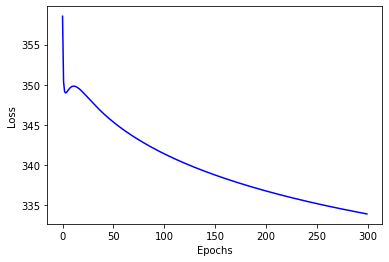

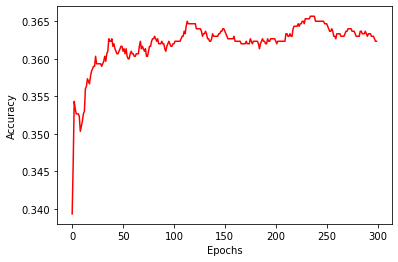

In [10]:
# 900 must -> image size, 6 must -> classification size, add number between 900 and 6 -> like [900, 150, 6]
object1 = CNN(layer_dims=[900, 6], num_epoch=300, learning_rate=0.02, last_layer_act_func="sigmoid", batch_size=64)
# I already converted input images to numpy array
object1.read_train("C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train") # 1 time enough
object1.read_train("C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test", modelname="validation") # 1 time enough
object1.load_train("train")
object1.load_train("validation")
object1.init_parameter()
object1.train()
object1.save_models()

## Multi Layer Neural Network

C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\buildings
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\forest
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\glacier
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\mountain
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\sea
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\street
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\buildings
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\forest
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\glacier
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\mountain
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\sea
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\street


  1%|          | 2/300 [00:00<00:27, 10.69it/s]


Iteration:  1 Total Loss:  368.6523700411403
Accuracy: 0.24833333333333332

Iteration:  2 Total Loss:  377.32424150119516
Accuracy: 0.269


  1%|▏         | 4/300 [00:00<00:31,  9.44it/s]


Iteration:  3 Total Loss:  360.8880943838742
Accuracy: 0.357

Iteration:  4 Total Loss:  343.6986599376479
Accuracy: 0.40066666666666667

Iteration:  5

  2%|▏         | 5/300 [00:00<00:32,  9.11it/s]

 Total Loss:  334.8287870700582
Accuracy: 0.408

Iteration:  6 Total Loss:  330.6487726862911
Accuracy: 0.41933333333333334

Iteration:  7 Total Loss:  328.186821461792


  3%|▎         | 9/300 [00:00<00:26, 11.12it/s]

Accuracy: 0.4236666666666667

Iteration:  8 Total Loss:  326.183161785681
Accuracy: 0.43233333333333335

Iteration:  9 Total Loss:  324.3660760392368
Accuracy: 0.43833333333333335


  4%|▎         | 11/300 [00:01<00:26, 11.07it/s]


Iteration:  10 Total Loss:  322.5906510887025
Accuracy: 0.442

Iteration:  11 Total Loss:  320.84302680345576
Accuracy: 0.44333333333333336

Iteration:  12 Total Loss:  319.1707536188005


  4%|▍         | 13/300 [00:01<00:26, 11.02it/s]

Accuracy: 0.446

Iteration:  13 Total Loss:  317.4874552965097
Accuracy: 0.449

Iteration:  14 Total Loss:  315.80621224467507
Accuracy: 0.4503333333333333


  6%|▌         | 17/300 [00:01<00:23, 11.80it/s]


Iteration:  15 Total Loss:  314.2167615725241
Accuracy: 0.45166666666666666

Iteration:  16 Total Loss:  312.7401191501337
Accuracy: 0.45166666666666666

Iteration:  17 Total Loss:  311.2882854395509
Accuracy: 0.452


  6%|▋         | 19/300 [00:01<00:23, 11.74it/s]


Iteration:  18 Total Loss:  309.9071041292044
Accuracy: 0.4563333333333333

Iteration:  19 Total Loss:  308.5995879188867
Accuracy: 0.4563333333333333

Iteration:  20 Total Loss:  307.34812868060334
Accuracy: 0.453


  7%|▋         | 21/300 [00:01<00:23, 12.12it/s]


Iteration:  21 Total Loss:  306.1290019518172
Accuracy: 0.45366666666666666

Iteration:  22 Total Loss:  304.9339907077738
Accuracy: 0.4533333333333333

Iteration:  23 Total Loss:  303.85233157025067


  8%|▊         | 25/300 [00:02<00:23, 11.82it/s]

Accuracy: 0.4553333333333333

Iteration:  24 Total Loss:  302.8203421157919
Accuracy: 0.455

Iteration:  25 Total Loss:  301.8024931249526
Accuracy: 0.4553333333333333


  9%|▉         | 27/300 [00:02<00:22, 12.35it/s]


Iteration:  26 Total Loss:  300.8718143800699
Accuracy: 0.455

Iteration:  27 Total Loss:  299.94639269438835
Accuracy: 0.4563333333333333

Iteration:  28 Total Loss:  299.08362352711623
Accuracy: 0.4563333333333333


 10%|█         | 31/300 [00:02<00:21, 12.46it/s]


Iteration:  29 Total Loss:  298.2901745912965
Accuracy: 0.4583333333333333

Iteration:  30 Total Loss:  297.48299792008265
Accuracy: 0.456

Iteration:  31 Total Loss:  296.79672019875426
Accuracy: 0.45666666666666667


 11%|█         | 33/300 [00:02<00:21, 12.33it/s]


Iteration:  32 Total Loss:  296.05627285964204
Accuracy: 0.46

Iteration:  33 Total Loss:  295.40753479640716
Accuracy: 0.46

Iteration:  34 Total Loss:  294.78595885377035
Accuracy: 0.4633333333333333


 12%|█▏        | 37/300 [00:03<00:21, 12.27it/s]


Iteration:  35 Total Loss:  294.15263454749305
Accuracy: 0.463

Iteration:  36 Total Loss:  293.5939137933398
Accuracy: 0.4623333333333333

Iteration:  37 Total Loss:  293.0211617625381
Accuracy: 0.464


 13%|█▎        | 39/300 [00:03<00:21, 11.96it/s]


Iteration:  38 Total Loss:  292.5524045357568
Accuracy: 0.46266666666666667

Iteration:  39 Total Loss:  292.04028599518904
Accuracy: 0.463

Iteration:  40 Total Loss:  291.5862219627328


 14%|█▎        | 41/300 [00:03<00:21, 11.99it/s]

Accuracy: 0.4633333333333333

Iteration:  41 Total Loss:  291.1087794312233
Accuracy: 0.46266666666666667

Iteration:  42 Total Loss:  290.62001983156097
Accuracy: 0.46366666666666667


 15%|█▌        | 45/300 [00:03<00:21, 12.11it/s]


Iteration:  43 Total Loss:  290.1677832692516
Accuracy: 0.4653333333333333

Iteration:  44 Total Loss:  289.6895314001204
Accuracy: 0.466

Iteration:  45 Total Loss:  289.27925395122463
Accuracy: 0.4666666666666667


 16%|█▌        | 47/300 [00:04<00:20, 12.31it/s]


Iteration:  46 Total Loss:  288.8676106823897
Accuracy: 0.4663333333333333

Iteration:  47 Total Loss:  288.45997249329844
Accuracy: 0.4673333333333333

Iteration:  48 Total Loss:  288.00971292225097
Accuracy: 0.4663333333333333


 17%|█▋        | 51/300 [00:04<00:20, 12.21it/s]


Iteration:  49 Total Loss:  287.6787146724186
Accuracy: 0.4676666666666667

Iteration:  50 Total Loss:  287.2601720815443
Accuracy: 0.467

Iteration:  51 Total Loss:  286.8641583562095
Accuracy: 0.4696666666666667


 18%|█▊        | 53/300 [00:04<00:20, 12.16it/s]


Iteration:  52 Total Loss:  286.4182778649263
Accuracy: 0.4696666666666667

Iteration:  53 Total Loss:  286.0980403664576
Accuracy: 0.4693333333333333

Iteration:  54 Total Loss:  285.6911494117554
Accuracy: 0.4696666666666667


 19%|█▉        | 57/300 [00:04<00:19, 12.38it/s]


Iteration:  55 Total Loss:  285.31553892112294
Accuracy: 0.471

Iteration:  56 Total Loss:  284.8814578534667
Accuracy: 0.4703333333333333

Iteration:  57 Total Loss:  284.5305517576517
Accuracy: 0.4713333333333333


 20%|█▉        | 59/300 [00:04<00:20, 11.95it/s]


Iteration:  58 Total Loss:  284.1451932538775
Accuracy: 0.4706666666666667

Iteration:  59 Total Loss:  283.7653281317779
Accuracy: 0.4713333333333333

Iteration:  60 Total Loss:  283.39468597345746
Accuracy: 0.4746666666666667


 20%|██        | 61/300 [00:05<00:19, 12.00it/s]


Iteration:  61 Total Loss:  283.00990897913545
Accuracy: 0.473

Iteration:  62 Total Loss:  282.65240532282826
Accuracy: 0.4726666666666667

Iteration:  63 Total Loss:  282.2305555506224


 22%|██▏       | 65/300 [00:05<00:19, 12.05it/s]

Accuracy: 0.475

Iteration:  64 Total Loss:  281.9010457249576
Accuracy: 0.47433333333333333

Iteration:  65 Total Loss:  281.5060866505385
Accuracy: 0.47433333333333333


 22%|██▏       | 67/300 [00:05<00:18, 12.27it/s]


Iteration:  66 Total Loss:  281.1968350901474
Accuracy: 0.4746666666666667

Iteration:  67 Total Loss:  280.7730023847249
Accuracy: 0.4746666666666667

Iteration:  68 Total Loss:  280.3955280826861
Accuracy: 0.47533333333333333


 24%|██▎       | 71/300 [00:05<00:18, 12.13it/s]


Iteration:  69 Total Loss:  280.02454629179437
Accuracy: 0.4723333333333333

Iteration:  70 Total Loss:  279.66005538978885
Accuracy: 0.4746666666666667

Iteration:  71 Total Loss:  279.31226251451614
Accuracy: 0.474


 24%|██▍       | 73/300 [00:06<00:18, 12.37it/s]


Iteration:  72 Total Loss:  278.89987284830664
Accuracy: 0.4756666666666667

Iteration:  73 Total Loss:  278.4799891176942
Accuracy: 0.472

Iteration:  74 Total Loss:  278.1773537409647
Accuracy: 0.472


 26%|██▌       | 77/300 [00:06<00:18, 12.29it/s]


Iteration:  75 Total Loss:  277.7996977354173
Accuracy: 0.472

Iteration:  76 Total Loss:  277.4069740210254
Accuracy: 0.471

Iteration:  77 Total Loss:  277.0064922724133
Accuracy: 0.473


 26%|██▋       | 79/300 [00:06<00:17, 12.28it/s]


Iteration:  78 Total Loss:  276.636027358166
Accuracy: 0.47433333333333333

Iteration:  79 Total Loss:  276.23728278483424
Accuracy: 0.4736666666666667

Iteration:  80 Total Loss:  275.8831157244809
Accuracy: 0.474


 28%|██▊       | 83/300 [00:06<00:17, 12.68it/s]


Iteration:  81 Total Loss:  275.50618807136215
Accuracy: 0.474

Iteration:  82 Total Loss:  275.1447290295453
Accuracy: 0.47433333333333333

Iteration:  83 Total Loss:  274.8478335990183
Accuracy: 0.47433333333333333


 28%|██▊       | 85/300 [00:07<00:16, 12.70it/s]


Iteration:  84 Total Loss:  274.49290808747463
Accuracy: 0.4756666666666667

Iteration:  85 Total Loss:  274.1371322546404
Accuracy: 0.477

Iteration:  86 Total Loss:  273.78650209571515
Accuracy: 0.47833333333333333


 30%|██▉       | 89/300 [00:07<00:16, 12.75it/s]


Iteration:  87 Total Loss:  273.4292254821082
Accuracy: 0.478

Iteration:  88 Total Loss:  273.0754658521073
Accuracy: 0.47833333333333333

Iteration:  89 Total Loss:  272.76238325734687
Accuracy: 0.47933333333333333


 30%|███       | 91/300 [00:07<00:16, 12.60it/s]


Iteration:  90 Total Loss:  272.4046661648081
Accuracy: 0.48033333333333333

Iteration:  91 Total Loss:  272.0388703779051
Accuracy: 0.4806666666666667

Iteration:  92 Total Loss:  271.6876476969591
Accuracy: 0.4786666666666667


 32%|███▏      | 95/300 [00:07<00:16, 12.34it/s]


Iteration:  93 Total Loss:  271.3791626782078
Accuracy: 0.479

Iteration:  94 Total Loss:  271.0452565971415
Accuracy: 0.478

Iteration:  95 Total Loss:  270.7230863055273
Accuracy: 0.477


 32%|███▏      | 97/300 [00:08<00:17, 11.77it/s]


Iteration:  96 Total Loss:  270.3933462495025
Accuracy: 0.476

Iteration:  97 Total Loss:  270.10931586256055
Accuracy: 0.47533333333333333

Iteration:  98 Total Loss:  269.79367695677524


 33%|███▎      | 99/300 [00:08<00:17, 11.75it/s]

Accuracy: 0.4766666666666667

Iteration:  99 Total Loss:  269.4221810056596
Accuracy: 0.473

Iteration:  100 Total Loss:  269.1133115121022
Accuracy: 0.4746666666666667


 34%|███▎      | 101/300 [00:08<00:16, 11.80it/s]


Iteration:  101 Total Loss:  268.7749195822974
Accuracy: 0.474

Iteration:  102 Total Loss:  268.4683881768885
Accuracy: 0.4746666666666667

Iteration:  103 Total Loss:  268.0641042056813


 34%|███▍      | 103/300 [00:08<00:17, 11.44it/s]

Accuracy: 0.47533333333333333

Iteration:  104 Total Loss:  267.74897569955635
Accuracy: 0.4726666666666667

Iteration:  

 36%|███▌      | 107/300 [00:08<00:16, 11.53it/s]

105 Total Loss:  267.4519040733807
Accuracy: 0.47533333333333333

Iteration:  106 Total Loss:  267.0419187407168
Accuracy: 0.4786666666666667

Iteration:  107 Total Loss:  266.72587916656755
Accuracy: 0.47533333333333333


 36%|███▋      | 109/300 [00:09<00:16, 11.64it/s]


Iteration:  108 Total Loss:  266.4950585731316
Accuracy: 0.477

Iteration:  109 Total Loss:  266.07104991874144
Accuracy: 0.478

Iteration:  110 Total Loss:  265.78620739263863
Accuracy: 0.47633333333333333


 38%|███▊      | 113/300 [00:09<00:15, 11.99it/s]


Iteration:  111 Total Loss:  265.47937934794487
Accuracy: 0.4756666666666667

Iteration:  112 Total Loss:  265.16793559834895
Accuracy: 0.4746666666666667

Iteration:  113 Total Loss:  264.94951836103854
Accuracy: 0.476


 38%|███▊      | 115/300 [00:09<00:15, 12.16it/s]


Iteration:  114 Total Loss:  264.58960739824914
Accuracy: 0.4736666666666667

Iteration:  115 Total Loss:  264.36915126084176
Accuracy: 0.4736666666666667

Iteration:  116 Total Loss:  264.0512735578954
Accuracy: 0.472


 40%|███▉      | 119/300 [00:09<00:14, 12.32it/s]


Iteration:  117 Total Loss:  263.695036682896
Accuracy: 0.472

Iteration:  118 Total Loss:  263.3881471890332
Accuracy: 0.4706666666666667

Iteration:  119 Total Loss:  263.0877690825422
Accuracy: 0.47


 40%|████      | 121/300 [00:10<00:14, 12.44it/s]


Iteration:  120 Total Loss:  262.8969690230788
Accuracy: 0.4676666666666667

Iteration:  121 Total Loss:  262.5252422488627
Accuracy: 0.47

Iteration:  122 Total Loss:  262.15691275401036
Accuracy: 0.472


 42%|████▏     | 125/300 [00:10<00:14, 12.26it/s]


Iteration:  123 Total Loss:  261.9293927213896
Accuracy: 0.4706666666666667

Iteration:  124 Total Loss:  261.6339321109647
Accuracy: 0.4723333333333333

Iteration:  125 Total Loss:  261.312597560632
Accuracy: 0.472


 42%|████▏     | 127/300 [00:10<00:14, 12.24it/s]


Iteration:  126 Total Loss:  261.0651052028188
Accuracy: 0.472

Iteration:  127 Total Loss:  260.7581092707647
Accuracy: 0.4726666666666667

Iteration:  128 Total Loss:  260.5979772757287
Accuracy: 0.4726666666666667


 44%|████▎     | 131/300 [00:10<00:13, 12.14it/s]


Iteration:  129 Total Loss:  260.31408919994317
Accuracy: 0.4716666666666667

Iteration:  130 Total Loss:  259.9668475054724
Accuracy: 0.4723333333333333

Iteration:  131 Total Loss:  259.6622554156756
Accuracy: 0.4706666666666667


 44%|████▍     | 133/300 [00:11<00:13, 12.13it/s]


Iteration:  132 Total Loss:  259.4128287540049
Accuracy: 0.47

Iteration:  133 Total Loss:  259.1424562730893
Accuracy: 0.473

Iteration:  134 Total Loss:  258.76390859816
Accuracy: 0.4713333333333333


 46%|████▌     | 137/300 [00:11<00:13, 12.29it/s]


Iteration:  135 Total Loss:  258.46613184874565
Accuracy: 0.4716666666666667

Iteration:  136 Total Loss:  258.2763454297891
Accuracy: 0.471

Iteration:  137 Total Loss:  258.0134745736312
Accuracy: 0.4686666666666667


 46%|████▋     | 139/300 [00:11<00:12, 12.47it/s]


Iteration:  138 Total Loss:  257.64482937205094
Accuracy: 0.47333333333333333

Iteration:  139 Total Loss:  257.4423520229731
Accuracy: 0.4706666666666667

Iteration:  140 Total Loss:  257.18428913254525
Accuracy: 0.469


 48%|████▊     | 143/300 [00:11<00:12, 12.78it/s]


Iteration:  141 Total Loss:  256.87540697305656
Accuracy: 0.469

Iteration:  142 Total Loss:  256.65627596647323
Accuracy: 0.47333333333333333

Iteration:  143 Total Loss:  256.3521078001983
Accuracy: 0.4696666666666667


 48%|████▊     | 145/300 [00:12<00:12, 12.60it/s]


Iteration:  144 Total Loss:  256.11093884781803
Accuracy: 0.471

Iteration:  145 Total Loss:  255.71888846724232
Accuracy: 0.47

Iteration:  146 Total Loss:  255.43466217160923
Accuracy: 0.469


 50%|████▉     | 149/300 [00:12<00:11, 12.70it/s]


Iteration:  147 Total Loss:  255.30693768118053
Accuracy: 0.4693333333333333

Iteration:  148 Total Loss:  255.06019850814283
Accuracy: 0.4696666666666667

Iteration:  149 Total Loss:  254.71765378129376
Accuracy: 0.472


 50%|█████     | 151/300 [00:12<00:11, 12.71it/s]


Iteration:  150 Total Loss:  254.50686156917342
Accuracy: 0.4726666666666667

Iteration:  151 Total Loss:  254.20846502471778
Accuracy: 0.4706666666666667

Iteration:  152 Total Loss:  253.87435246744977
Accuracy: 0.4723333333333333


 52%|█████▏    | 155/300 [00:12<00:11, 12.74it/s]


Iteration:  153 Total Loss:  253.8363060369425
Accuracy: 0.471

Iteration:  154 Total Loss:  253.50134441056298
Accuracy: 0.4703333333333333

Iteration:  155 Total Loss:  253.34755388600215
Accuracy: 0.4686666666666667


 52%|█████▏    | 157/300 [00:12<00:11, 12.59it/s]


Iteration:  156 Total Loss:  252.96877759032935
Accuracy: 0.4706666666666667

Iteration:  157 Total Loss:  252.68169197133074
Accuracy: 0.4693333333333333

Iteration:  158 Total Loss:  252.38662073966302
Accuracy: 0.4726666666666667


 54%|█████▎    | 161/300 [00:13<00:11, 12.57it/s]


Iteration:  159 Total Loss:  252.16058849263547
Accuracy: 0.4703333333333333

Iteration:  160 Total Loss:  252.0370338256102
Accuracy: 0.472

Iteration:  161 Total Loss:  251.77027443505182
Accuracy: 0.4703333333333333


 54%|█████▍    | 163/300 [00:13<00:11, 11.90it/s]


Iteration:  162 Total Loss:  251.64486652857363
Accuracy: 0.469

Iteration:  163 Total Loss:  251.24706911514983
Accuracy: 0.4693333333333333

Iteration:  164 Total Loss:  251.05934844406815
Accuracy: 0.4676666666666667


 56%|█████▌    | 167/300 [00:13<00:11, 11.88it/s]


Iteration:  165 Total Loss:  250.86697651425186
Accuracy: 0.468

Iteration:  166 Total Loss:  250.77183962518532
Accuracy: 0.468

Iteration:  167 Total Loss:  250.3656223801287
Accuracy: 0.4696666666666667


 56%|█████▋    | 169/300 [00:13<00:11, 11.80it/s]


Iteration:  168 Total Loss:  250.15292652710886
Accuracy: 0.468

Iteration:  169 Total Loss:  249.77663577113748
Accuracy: 0.4673333333333333

Iteration:  170 Total Loss:  249.67467042473817
Accuracy: 0.466


 58%|█████▊    | 173/300 [00:14<00:10, 11.69it/s]


Iteration:  171 Total Loss:  249.39190290013602
Accuracy: 0.466

Iteration:  172 Total Loss:  249.17091708746005
Accuracy: 0.4726666666666667

Iteration:  173 Total Loss:  248.75560874903204
Accuracy: 0.472


 58%|█████▊    | 175/300 [00:14<00:10, 11.84it/s]


Iteration:  174 Total Loss:  248.5033025347146
Accuracy: 0.4683333333333333

Iteration:  175 Total Loss:  248.21548281208936
Accuracy: 0.466

Iteration:  176 Total Loss:  247.971029287518
Accuracy: 0.469


 60%|█████▉    | 179/300 [00:14<00:09, 12.42it/s]


Iteration:  177 Total Loss:  247.91607014069658
Accuracy: 0.4673333333333333

Iteration:  178 Total Loss:  247.6271054378575
Accuracy: 0.464

Iteration:  179 Total Loss:  247.45658702954756
Accuracy: 0.4666666666666667


 60%|██████    | 181/300 [00:14<00:09, 12.24it/s]


Iteration:  180 Total Loss:  247.07596260073285
Accuracy: 0.467

Iteration:  181 Total Loss:  246.9168091963006
Accuracy: 0.466

Iteration:  182 Total Loss:  246.61755062172986
Accuracy: 0.468


 61%|██████    | 183/300 [00:15<00:09, 11.96it/s]


Iteration:  183 Total Loss:  246.4130204717355
Accuracy: 0.467

Iteration:  184 Total Loss:  246.29419126959192
Accuracy: 0.4643333333333333

Iteration:  185

 62%|██████▏   | 185/300 [00:15<00:10, 11.18it/s]

 Total Loss:  246.1936745816952
Accuracy: 0.465

Iteration:  186 Total Loss:  245.68470347819834
Accuracy: 0.463

Iteration:  187 Total Loss:  245.77873851166711


 62%|██████▏   | 187/300 [00:15<00:10, 10.73it/s]

Accuracy: 0.4663333333333333

Iteration:  188 Total Loss:  245.55761523245033
Accuracy: 0.4646666666666667

Iteration:  189 Total Loss:  245.23507653720134


 63%|██████▎   | 189/300 [00:15<00:10, 10.42it/s]

Accuracy: 0.465

Iteration:  190 Total Loss:  244.88633192537534
Accuracy: 0.4643333333333333

Iteration:  

 64%|██████▍   | 193/300 [00:16<00:09, 10.89it/s]

191 Total Loss:  244.8489427503951
Accuracy: 0.4646666666666667

Iteration:  192 Total Loss:  244.53198939370057
Accuracy: 0.4653333333333333

Iteration:  193 Total Loss:  244.46884462905902
Accuracy: 0.4666666666666667


 65%|██████▌   | 195/300 [00:16<00:09, 11.20it/s]


Iteration:  194 Total Loss:  244.08151218947236
Accuracy: 0.466

Iteration:  195 Total Loss:  244.15428070563797
Accuracy: 0.4693333333333333

Iteration:  196 Total Loss:  243.5917597752579
Accuracy: 0.466


 66%|██████▋   | 199/300 [00:16<00:08, 11.80it/s]


Iteration:  197 Total Loss:  243.42330207330085
Accuracy: 0.467

Iteration:  198 Total Loss:  243.4222613118119
Accuracy: 0.465

Iteration:  199 Total Loss:  243.00961439468676
Accuracy: 0.4663333333333333


 67%|██████▋   | 201/300 [00:16<00:08, 12.17it/s]


Iteration:  200 Total Loss:  242.94990872749602
Accuracy: 0.46

Iteration:  201 Total Loss:  242.5907950441533
Accuracy: 0.4656666666666667

Iteration:  202 Total Loss:  242.970057444145
Accuracy: 0.4686666666666667


 68%|██████▊   | 205/300 [00:17<00:07, 12.10it/s]


Iteration:  203 Total Loss:  242.20423016254645
Accuracy: 0.4666666666666667

Iteration:  204 Total Loss:  242.11158826493747
Accuracy: 0.46066666666666667

Iteration:  205 Total Loss:  241.99805606577104
Accuracy: 0.4683333333333333


 69%|██████▉   | 207/300 [00:17<00:07, 12.13it/s]


Iteration:  206 Total Loss:  241.59636236088795
Accuracy: 0.4696666666666667

Iteration:  207 Total Loss:  241.2508429526452
Accuracy: 0.4666666666666667

Iteration:  208 Total Loss:  241.0258069619465
Accuracy: 0.462


 70%|███████   | 211/300 [00:17<00:07, 12.19it/s]


Iteration:  209 Total Loss:  241.23974856341826
Accuracy: 0.4673333333333333

Iteration:  210 Total Loss:  240.51928274056814
Accuracy: 0.4653333333333333

Iteration:  211 Total Loss:  240.9767821108677
Accuracy: 0.46266666666666667


 71%|███████   | 213/300 [00:17<00:07, 12.23it/s]


Iteration:  212 Total Loss:  240.74934653356974
Accuracy: 0.467

Iteration:  213 Total Loss:  240.27831921456809
Accuracy: 0.4683333333333333

Iteration:  214 Total Loss:  240.29503300945876
Accuracy: 0.45866666666666667


 72%|███████▏  | 217/300 [00:18<00:06, 12.54it/s]


Iteration:  215 Total Loss:  240.0887814435813
Accuracy: 0.465

Iteration:  216 Total Loss:  239.90010157477644
Accuracy: 0.4603333333333333

Iteration:  217 Total Loss:  239.72584548976928
Accuracy: 0.466


 73%|███████▎  | 219/300 [00:18<00:06, 12.50it/s]


Iteration:  218 Total Loss:  239.16970946847488
Accuracy: 0.46

Iteration:  219 Total Loss:  239.24879320767923
Accuracy: 0.46166666666666667

Iteration:  220 Total Loss:  239.12462508570363
Accuracy: 0.4623333333333333


 74%|███████▍  | 223/300 [00:18<00:06, 12.61it/s]


Iteration:  221 Total Loss:  238.5290373057513
Accuracy: 0.4593333333333333

Iteration:  222 Total Loss:  238.4335247684221
Accuracy: 0.46166666666666667

Iteration:  223 Total Loss:  238.39117478467205
Accuracy: 0.4646666666666667


 75%|███████▌  | 225/300 [00:18<00:05, 12.67it/s]


Iteration:  224 Total Loss:  238.39708942015227
Accuracy: 0.4563333333333333

Iteration:  225 Total Loss:  238.12664294473896
Accuracy: 0.4523333333333333

Iteration:  226 Total Loss:  238.0728833398538
Accuracy: 0.46266666666666667


 76%|███████▋  | 229/300 [00:19<00:05, 12.67it/s]


Iteration:  227 Total Loss:  238.06749359566876
Accuracy: 0.4563333333333333

Iteration:  228 Total Loss:  237.57442747583727
Accuracy: 0.45566666666666666

Iteration:  229 Total Loss:  237.65326895253318
Accuracy: 0.459


 77%|███████▋  | 231/300 [00:19<00:05, 12.67it/s]


Iteration:  230 Total Loss:  237.1611353111373
Accuracy: 0.457

Iteration:  231 Total Loss:  236.86232634455413
Accuracy: 0.45866666666666667

Iteration:  232 Total Loss:  236.7387954467036
Accuracy: 0.46166666666666667


 78%|███████▊  | 235/300 [00:19<00:05, 12.47it/s]


Iteration:  233 Total Loss:  236.59407244376953
Accuracy: 0.4583333333333333

Iteration:  234 Total Loss:  236.0632185286712
Accuracy: 0.45366666666666666

Iteration:  235 Total Loss:  236.19461045098035
Accuracy: 0.46066666666666667


 79%|███████▉  | 237/300 [00:19<00:05, 12.38it/s]


Iteration:  236 Total Loss:  235.79337315210873
Accuracy: 0.463

Iteration:  237 Total Loss:  235.73376879263435
Accuracy: 0.46166666666666667

Iteration:  238 Total Loss:  235.52401267604526
Accuracy: 0.4613333333333333


 80%|████████  | 241/300 [00:19<00:04, 12.78it/s]


Iteration:  239 Total Loss:  235.29815478243387
Accuracy: 0.46

Iteration:  240 Total Loss:  235.25436355712836
Accuracy: 0.463

Iteration:  241 Total Loss:  234.84696513914147
Accuracy: 0.4613333333333333


 81%|████████  | 243/300 [00:20<00:04, 12.74it/s]


Iteration:  242 Total Loss:  235.00779547379958
Accuracy: 0.462

Iteration:  243 Total Loss:  234.63834079566794
Accuracy: 0.464

Iteration:  244 Total Loss:  234.41883089192396
Accuracy: 0.461


 82%|████████▏ | 247/300 [00:20<00:04, 12.19it/s]


Iteration:  245 Total Loss:  234.3196997214184
Accuracy: 0.46166666666666667

Iteration:  246 Total Loss:  233.9832509253928
Accuracy: 0.4603333333333333

Iteration:  247 Total Loss:  233.80447283639327
Accuracy: 0.461


 83%|████████▎ | 249/300 [00:20<00:04, 12.19it/s]


Iteration:  248 Total Loss:  234.14108026766132
Accuracy: 0.461

Iteration:  249 Total Loss:  233.4066088375678
Accuracy: 0.462

Iteration:  250 Total Loss:  

 84%|████████▎ | 251/300 [00:20<00:04, 11.93it/s]

233.24126513673136
Accuracy: 0.4593333333333333

Iteration:  251 Total Loss:  233.03001592320615
Accuracy: 0.463

Iteration:  252 Total Loss:  232.7185026983696
Accuracy: 0.458


 85%|████████▌ | 255/300 [00:21<00:03, 11.96it/s]


Iteration:  253 Total Loss:  232.95615851343328
Accuracy: 0.4603333333333333

Iteration:  254 Total Loss:  233.00737641565985
Accuracy: 0.46166666666666667

Iteration:  255 Total Loss:  232.42399408896793
Accuracy: 0.46


 86%|████████▌ | 257/300 [00:21<00:03, 12.32it/s]


Iteration:  256 Total Loss:  232.57561897842567
Accuracy: 0.45666666666666667

Iteration:  257 Total Loss:  232.12968189590313
Accuracy: 0.4613333333333333

Iteration:  258 Total Loss:  231.83023008101202
Accuracy: 0.461


 86%|████████▋ | 259/300 [00:21<00:03, 11.95it/s]


Iteration:  259 Total Loss:  232.00695395328083
Accuracy: 0.46166666666666667

Iteration:  260 Total Loss:  231.60417988376534
Accuracy: 0.4603333333333333

Iteration:  261 Total Loss:  231.30832705272616


 88%|████████▊ | 263/300 [00:21<00:03, 11.70it/s]

Accuracy: 0.4593333333333333

Iteration:  262 Total Loss:  231.71331032072862
Accuracy: 0.4583333333333333

Iteration:  263 Total Loss:  231.00668610016203
Accuracy: 0.461


 88%|████████▊ | 265/300 [00:21<00:02, 12.04it/s]


Iteration:  264 Total Loss:  230.90441382028735
Accuracy: 0.455

Iteration:  265 Total Loss:  230.39209074596738
Accuracy: 0.4573333333333333

Iteration:  266 Total Loss:  230.85028621987425
Accuracy: 0.45866666666666667


 90%|████████▉ | 269/300 [00:22<00:02, 12.30it/s]


Iteration:  267 Total Loss:  230.43643515647835
Accuracy: 0.461

Iteration:  268 Total Loss:  230.9870391635437
Accuracy: 0.462

Iteration:  269 Total Loss:  229.94701593915198
Accuracy: 0.4583333333333333


 90%|█████████ | 271/300 [00:22<00:02, 12.22it/s]


Iteration:  270 Total Loss:  229.23051845060567
Accuracy: 0.4583333333333333

Iteration:  271 Total Loss:  229.73555862449058
Accuracy: 0.4593333333333333

Iteration:  272 Total Loss:  229.85088406480494
Accuracy: 0.458


 91%|█████████ | 273/300 [00:22<00:02, 11.93it/s]


Iteration:  273 Total Loss:  228.90449505583405
Accuracy: 0.4603333333333333

Iteration:  274 Total Loss:  230.06928103255464
Accuracy: 0.461

Iteration:  275 Total Loss:  229.8242417956729


 92%|█████████▏| 275/300 [00:22<00:02, 11.35it/s]

Accuracy: 0.465

Iteration:  276 Total Loss:  228.98629350551465
Accuracy: 0.46066666666666667

Iteration:  277 Total Loss:  228.9451214003579


 93%|█████████▎| 279/300 [00:23<00:01, 11.31it/s]

Accuracy: 0.45866666666666667

Iteration:  278 Total Loss:  228.54775940510802
Accuracy: 0.45966666666666667

Iteration:  279 Total Loss:  228.47444274350738
Accuracy: 0.4646666666666667


 94%|█████████▎| 281/300 [00:23<00:01, 11.40it/s]


Iteration:  280 Total Loss:  228.60985917407095
Accuracy: 0.45966666666666667

Iteration:  281 Total Loss:  228.22037366683654
Accuracy: 0.455

Iteration:  282 Total Loss:  228.20282110285183
Accuracy: 0.462


 95%|█████████▌| 285/300 [00:23<00:01, 11.67it/s]


Iteration:  283 Total Loss:  227.84366055826612
Accuracy: 0.46166666666666667

Iteration:  284 Total Loss:  227.23500520347858
Accuracy: 0.4543333333333333

Iteration:  285 Total Loss:  227.85974360729412
Accuracy: 0.46266666666666667


 96%|█████████▌| 287/300 [00:23<00:01, 11.72it/s]


Iteration:  286 Total Loss:  227.82252431276882
Accuracy: 0.46

Iteration:  287 Total Loss:  226.96276391417715
Accuracy: 0.464

Iteration:  288 Total Loss:  226.82773038534373
Accuracy: 0.4623333333333333


 96%|█████████▋| 289/300 [00:24<00:00, 11.67it/s]


Iteration:  289 Total Loss:  226.7502387551587
Accuracy: 0.45866666666666667

Iteration:  290 Total Loss:  226.75468608129793
Accuracy: 0.459

Iteration:  291 Total Loss:  226.59664636758956


 98%|█████████▊| 293/300 [00:24<00:00, 11.54it/s]

Accuracy: 0.4643333333333333

Iteration:  292 Total Loss:  226.79911195034046
Accuracy: 0.46

Iteration:  293 Total Loss:  226.82514655537258
Accuracy: 0.45666666666666667


 98%|█████████▊| 295/300 [00:24<00:00, 11.22it/s]


Iteration:  294 Total Loss:  225.86492659871539
Accuracy: 0.46066666666666667

Iteration:  295 Total Loss:  226.25624955645597
Accuracy: 0.462

Iteration:  296 Total Loss:  226.3266587798203


 99%|█████████▉| 297/300 [00:24<00:00, 11.55it/s]

Accuracy: 0.466

Iteration:  297 Total Loss:  226.3183954520467
Accuracy: 0.45566666666666666

Iteration:  298 Total Loss:  226.48854484718376
Accuracy: 0.46266666666666667


100%|██████████| 300/300 [00:24<00:00, 12.01it/s]


Iteration:  299 Total Loss:  224.77375847161767
Accuracy: 0.46

Iteration:  300 Total Loss:  225.81666658571058
Accuracy: 0.4643333333333333


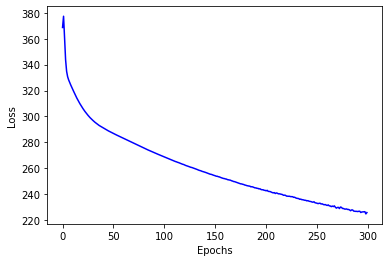

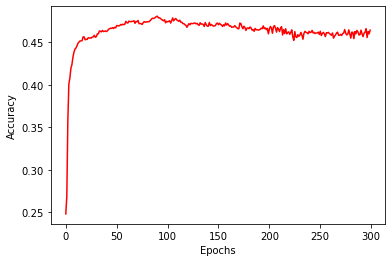

In [11]:
# 900 must -> image size, 6 must -> classification size, add number between 900 and 6 -> like [900, 150, 6]
object1 = CNN(layer_dims=[900,30, 6], num_epoch=300, learning_rate=0.02, last_layer_act_func="sigmoid", batch_size=64)
# I already converted input images to numpy array
object1.read_train("C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train") # 1 time enough
object1.read_train("C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test", modelname="validation") # 1 time enough
object1.load_train("train")
object1.load_train("validation")
object1.init_parameter()
object1.train()
object1.save_models()

### 2 hidden layer

C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\buildings
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\forest
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\glacier
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\mountain
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\sea
C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train\street
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\buildings
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\forest
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\glacier
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\mountain
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\sea
C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test\street


  0%|          | 1/300 [00:00<04:55,  1.01it/s]


Iteration:  1 Total Loss:  351.8322404803619
Accuracy: 0.175


  1%|          | 2/300 [00:01<04:54,  1.01it/s]


Iteration:  2 Total Loss:  390.0045878669114
Accuracy: 0.18633333333333332


  1%|          | 3/300 [00:02<04:53,  1.01it/s]


Iteration:  3 Total Loss:  380.009109209036
Accuracy: 0.2776666666666667


  1%|▏         | 4/300 [00:03<04:52,  1.01it/s]


Iteration:  4 Total Loss:  359.54839171014663
Accuracy: 0.2816666666666667


  2%|▏         | 5/300 [00:04<04:50,  1.01it/s]


Iteration:  5 Total Loss:  352.8263560311664
Accuracy: 0.323


  2%|▏         | 6/300 [00:05<04:50,  1.01it/s]


Iteration:  6 Total Loss:  344.0640149647961
Accuracy: 0.358


  2%|▏         | 7/300 [00:06<04:54,  1.01s/it]


Iteration:  7 Total Loss:  337.9291720704487
Accuracy: 0.36666666666666664


  3%|▎         | 8/300 [00:07<04:55,  1.01s/it]


Iteration:  8 Total Loss:  335.21051850910754
Accuracy: 0.37833333333333335


  3%|▎         | 9/300 [00:08<04:51,  1.00s/it]


Iteration:  9 Total Loss:  332.0464239928106
Accuracy: 0.394


  3%|▎         | 10/300 [00:09<04:47,  1.01it/s]


Iteration:  10 Total Loss:  328.19682051293273
Accuracy: 0.4056666666666667


  4%|▎         | 11/300 [00:10<04:49,  1.00s/it]


Iteration:  11 Total Loss:  324.3856507630391
Accuracy: 0.41533333333333333


  4%|▍         | 12/300 [00:11<04:46,  1.00it/s]


Iteration:  12 Total Loss:  321.2724602292472
Accuracy: 0.422


  4%|▍         | 13/300 [00:13<04:50,  1.01s/it]


Iteration:  13 Total Loss:  318.7821963219722
Accuracy: 0.42733333333333334


  5%|▍         | 14/300 [00:14<04:48,  1.01s/it]


Iteration:  14 Total Loss:  316.658981961694
Accuracy: 0.42933333333333334


  5%|▌         | 15/300 [00:15<04:47,  1.01s/it]


Iteration:  15 Total Loss:  314.70541843142877
Accuracy: 0.427


  5%|▌         | 16/300 [00:16<04:45,  1.00s/it]


Iteration:  16 Total Loss:  312.9102392454338
Accuracy: 0.42766666666666664


  6%|▌         | 17/300 [00:16<04:42,  1.00it/s]


Iteration:  17 Total Loss:  311.24938745223005
Accuracy: 0.43133333333333335


  6%|▌         | 18/300 [00:17<04:39,  1.01it/s]


Iteration:  18 Total Loss:  309.7314838944689
Accuracy: 0.43166666666666664


  6%|▋         | 19/300 [00:19<04:48,  1.03s/it]


Iteration:  19 Total Loss:  308.3215675747561
Accuracy: 0.43133333333333335


  7%|▋         | 20/300 [00:20<04:53,  1.05s/it]


Iteration:  20 Total Loss:  306.87702675306974
Accuracy: 0.43233333333333335


  7%|▋         | 21/300 [00:21<04:52,  1.05s/it]


Iteration:  21 Total Loss:  305.4405862538199
Accuracy: 0.43466666666666665


  7%|▋         | 22/300 [00:22<04:53,  1.06s/it]


Iteration:  22 Total Loss:  303.9344523545113
Accuracy: 0.43533333333333335


  8%|▊         | 23/300 [00:23<04:51,  1.05s/it]


Iteration:  23 Total Loss:  302.30967555459296
Accuracy: 0.438


  8%|▊         | 24/300 [00:24<04:51,  1.06s/it]


Iteration:  24 Total Loss:  300.56971825362103
Accuracy: 0.44066666666666665


  8%|▊         | 25/300 [00:25<04:45,  1.04s/it]


Iteration:  25 Total Loss:  298.7347577159714
Accuracy: 0.44766666666666666


  9%|▊         | 26/300 [00:26<04:44,  1.04s/it]


Iteration:  26 Total Loss:  296.7508899085968
Accuracy: 0.4483333333333333


  9%|▉         | 27/300 [00:27<04:39,  1.02s/it]


Iteration:  27 Total Loss:  294.72208447786
Accuracy: 0.4503333333333333


  9%|▉         | 28/300 [00:28<04:36,  1.02s/it]


Iteration:  28 Total Loss:  292.72181386854027
Accuracy: 0.45266666666666666


 10%|▉         | 29/300 [00:29<04:32,  1.01s/it]


Iteration:  29 Total Loss:  290.87054080581123
Accuracy: 0.451


 10%|█         | 30/300 [00:30<04:29,  1.00it/s]


Iteration:  30 Total Loss:  289.07707146749715
Accuracy: 0.4563333333333333


 10%|█         | 31/300 [00:31<04:28,  1.00it/s]


Iteration:  31 Total Loss:  287.47426280673943
Accuracy: 0.461


 11%|█         | 32/300 [00:32<04:26,  1.01it/s]


Iteration:  32 Total Loss:  286.0348442258317
Accuracy: 0.464


 11%|█         | 33/300 [00:33<04:30,  1.01s/it]


Iteration:  33 Total Loss:  284.6088067398979
Accuracy: 0.4633333333333333


 11%|█▏        | 34/300 [00:34<04:35,  1.03s/it]


Iteration:  34 Total Loss:  283.3227125573724
Accuracy: 0.4653333333333333


 12%|█▏        | 35/300 [00:35<04:35,  1.04s/it]


Iteration:  35 Total Loss:  282.121351125049
Accuracy: 0.465


 12%|█▏        | 36/300 [00:36<04:42,  1.07s/it]


Iteration:  36 Total Loss:  280.9089792276776
Accuracy: 0.4686666666666667


 12%|█▏        | 37/300 [00:37<04:43,  1.08s/it]


Iteration:  37 Total Loss:  279.8681957667686
Accuracy: 0.4703333333333333


 13%|█▎        | 38/300 [00:38<04:41,  1.07s/it]


Iteration:  38 Total Loss:  278.6936255561643
Accuracy: 0.4706666666666667


 13%|█▎        | 39/300 [00:40<04:47,  1.10s/it]


Iteration:  39 Total Loss:  277.6170748102618
Accuracy: 0.474


 13%|█▎        | 40/300 [00:41<04:42,  1.09s/it]


Iteration:  40 Total Loss:  276.5719719243734
Accuracy: 0.47433333333333333


 14%|█▎        | 41/300 [00:42<04:40,  1.08s/it]


Iteration:  41 Total Loss:  275.50591539475687
Accuracy: 0.47533333333333333


 14%|█▍        | 42/300 [00:43<04:42,  1.09s/it]


Iteration:  42 Total Loss:  274.4891649371204
Accuracy: 0.47333333333333333


 14%|█▍        | 43/300 [00:44<04:49,  1.13s/it]


Iteration:  43 Total Loss:  273.48154976798605
Accuracy: 0.4716666666666667


 15%|█▍        | 44/300 [00:45<04:40,  1.10s/it]


Iteration:  44 Total Loss:  272.4733682741509
Accuracy: 0.4716666666666667


 15%|█▌        | 45/300 [00:46<04:34,  1.08s/it]


Iteration:  45 Total Loss:  271.5496499781638
Accuracy: 0.47433333333333333


 15%|█▌        | 46/300 [00:47<04:31,  1.07s/it]


Iteration:  46 Total Loss:  270.557871870884
Accuracy: 0.475


 16%|█▌        | 47/300 [00:48<04:26,  1.05s/it]


Iteration:  47 Total Loss:  269.62639776336954
Accuracy: 0.477


 16%|█▌        | 48/300 [00:49<04:22,  1.04s/it]


Iteration:  48 Total Loss:  268.587864845743
Accuracy: 0.47633333333333333


 16%|█▋        | 49/300 [00:50<04:21,  1.04s/it]


Iteration:  49 Total Loss:  267.6168951831694
Accuracy: 0.47533333333333333


 17%|█▋        | 50/300 [00:51<04:19,  1.04s/it]


Iteration:  50 Total Loss:  266.60359574764243
Accuracy: 0.47533333333333333


 17%|█▋        | 51/300 [00:52<04:16,  1.03s/it]


Iteration:  51 Total Loss:  265.67362458438737
Accuracy: 0.47633333333333333


 17%|█▋        | 52/300 [00:54<04:37,  1.12s/it]


Iteration:  52 Total Loss:  264.72900448452526
Accuracy: 0.476


 18%|█▊        | 53/300 [00:55<04:28,  1.09s/it]


Iteration:  53 Total Loss:  263.7994274243942
Accuracy: 0.47933333333333333


 18%|█▊        | 54/300 [00:56<04:27,  1.09s/it]


Iteration:  54 Total Loss:  262.8736713206132
Accuracy: 0.4766666666666667


 18%|█▊        | 55/300 [00:57<04:26,  1.09s/it]


Iteration:  55 Total Loss:  261.8667942133554
Accuracy: 0.47533333333333333


 19%|█▊        | 56/300 [00:58<04:22,  1.07s/it]


Iteration:  56 Total Loss:  260.94760451867
Accuracy: 0.478


 19%|█▉        | 57/300 [00:59<04:21,  1.07s/it]


Iteration:  57 Total Loss:  259.9154943110248
Accuracy: 0.47733333333333333


 19%|█▉        | 58/300 [01:00<04:20,  1.08s/it]


Iteration:  58 Total Loss:  258.9103226592966
Accuracy: 0.476


 20%|█▉        | 59/300 [01:01<04:17,  1.07s/it]


Iteration:  59 Total Loss:  257.9473923241745
Accuracy: 0.48033333333333333


 20%|██        | 60/300 [01:02<04:10,  1.04s/it]


Iteration:  60 Total Loss:  256.85941105242705
Accuracy: 0.48233333333333334


 20%|██        | 61/300 [01:03<04:06,  1.03s/it]


Iteration:  61 Total Loss:  255.89653339635117
Accuracy: 0.48


 21%|██        | 62/300 [01:04<04:03,  1.02s/it]


Iteration:  62 Total Loss:  254.9173622579958
Accuracy: 0.47633333333333333


 21%|██        | 63/300 [01:05<03:59,  1.01s/it]


Iteration:  63 Total Loss:  253.84994951512368
Accuracy: 0.478


 21%|██▏       | 64/300 [01:06<03:57,  1.01s/it]


Iteration:  64 Total Loss:  252.72189316883572
Accuracy: 0.47433333333333333


 22%|██▏       | 65/300 [01:07<03:54,  1.00it/s]


Iteration:  65 Total Loss:  251.80524268449034
Accuracy: 0.4726666666666667


 22%|██▏       | 66/300 [01:08<03:52,  1.01it/s]


Iteration:  66 Total Loss:  250.72118024374052
Accuracy: 0.4726666666666667


 22%|██▏       | 67/300 [01:09<03:49,  1.01it/s]


Iteration:  67 Total Loss:  249.6510583982543
Accuracy: 0.473


 23%|██▎       | 68/300 [01:10<03:53,  1.01s/it]


Iteration:  68 Total Loss:  248.6512110056982
Accuracy: 0.47733333333333333


 23%|██▎       | 69/300 [01:11<04:02,  1.05s/it]


Iteration:  69 Total Loss:  247.54396759415334
Accuracy: 0.475


 23%|██▎       | 70/300 [01:12<03:58,  1.04s/it]


Iteration:  70 Total Loss:  246.6123361063137
Accuracy: 0.474


 24%|██▎       | 71/300 [01:13<03:55,  1.03s/it]


Iteration:  71 Total Loss:  245.65240808079997
Accuracy: 0.4776666666666667


 24%|██▍       | 72/300 [01:14<03:56,  1.04s/it]


Iteration:  72 Total Loss:  244.4914443476876
Accuracy: 0.47633333333333333


 24%|██▍       | 73/300 [01:15<03:53,  1.03s/it]


Iteration:  73 Total Loss:  243.30594783598394
Accuracy: 0.4816666666666667


 25%|██▍       | 74/300 [01:16<03:48,  1.01s/it]


Iteration:  74 Total Loss:  242.31549972059062
Accuracy: 0.475


 25%|██▌       | 75/300 [01:17<03:47,  1.01s/it]


Iteration:  75 Total Loss:  241.43617163600757
Accuracy: 0.482


 25%|██▌       | 76/300 [01:18<03:45,  1.01s/it]


Iteration:  76 Total Loss:  240.1138407321393
Accuracy: 0.481


 26%|██▌       | 77/300 [01:19<03:43,  1.00s/it]


Iteration:  77 Total Loss:  239.05488746658253
Accuracy: 0.4776666666666667


 26%|██▌       | 78/300 [01:20<03:42,  1.00s/it]


Iteration:  78 Total Loss:  238.4436422740644
Accuracy: 0.481


 26%|██▋       | 79/300 [01:21<03:50,  1.04s/it]


Iteration:  79 Total Loss:  237.2774323793442
Accuracy: 0.4796666666666667


 27%|██▋       | 80/300 [01:22<03:50,  1.05s/it]


Iteration:  80 Total Loss:  236.37251674267213
Accuracy: 0.4806666666666667


 27%|██▋       | 81/300 [01:23<03:46,  1.03s/it]


Iteration:  81 Total Loss:  235.0192177941016
Accuracy: 0.47633333333333333


 27%|██▋       | 82/300 [01:24<03:42,  1.02s/it]


Iteration:  82 Total Loss:  234.17199405934528
Accuracy: 0.481


 28%|██▊       | 83/300 [01:25<03:42,  1.02s/it]


Iteration:  83 Total Loss:  233.00760311818874
Accuracy: 0.488


 28%|██▊       | 84/300 [01:27<03:51,  1.07s/it]


Iteration:  84 Total Loss:  232.11098814323648
Accuracy: 0.48533333333333334


 28%|██▊       | 85/300 [01:28<04:02,  1.13s/it]


Iteration:  85 Total Loss:  230.75668928924057
Accuracy: 0.4776666666666667


 29%|██▊       | 86/300 [01:29<04:03,  1.14s/it]


Iteration:  86 Total Loss:  230.12518388292116
Accuracy: 0.4846666666666667


 29%|██▉       | 87/300 [01:30<03:55,  1.10s/it]


Iteration:  87 Total Loss:  228.80605199569396
Accuracy: 0.497


 29%|██▉       | 88/300 [01:31<03:46,  1.07s/it]


Iteration:  88 Total Loss:  227.4407267248566
Accuracy: 0.498


 30%|██▉       | 89/300 [01:32<03:44,  1.06s/it]


Iteration:  89 Total Loss:  226.77105112163594
Accuracy: 0.49


 30%|███       | 90/300 [01:33<03:39,  1.04s/it]


Iteration:  90 Total Loss:  225.79992850382362
Accuracy: 0.493


 30%|███       | 91/300 [01:34<03:33,  1.02s/it]


Iteration:  91 Total Loss:  224.83135045483175
Accuracy: 0.49566666666666664


 31%|███       | 92/300 [01:35<03:29,  1.01s/it]


Iteration:  92 Total Loss:  224.0588946114252
Accuracy: 0.494


 31%|███       | 93/300 [01:36<03:27,  1.00s/it]


Iteration:  93 Total Loss:  222.82521028695692
Accuracy: 0.49366666666666664


 31%|███▏      | 94/300 [01:37<03:25,  1.00it/s]


Iteration:  94 Total Loss:  221.48551214910546
Accuracy: 0.496


 32%|███▏      | 95/300 [01:38<03:25,  1.00s/it]


Iteration:  95 Total Loss:  220.86751125079562
Accuracy: 0.493


 32%|███▏      | 96/300 [01:39<03:27,  1.02s/it]


Iteration:  96 Total Loss:  220.32043814831576
Accuracy: 0.5066666666666667


 32%|███▏      | 97/300 [01:40<03:25,  1.01s/it]


Iteration:  97 Total Loss:  219.15184620138
Accuracy: 0.48833333333333334


 33%|███▎      | 98/300 [01:41<03:28,  1.03s/it]


Iteration:  98 Total Loss:  217.92245508591438
Accuracy: 0.509


 33%|███▎      | 99/300 [01:42<03:27,  1.03s/it]


Iteration:  99 Total Loss:  217.60852855042435
Accuracy: 0.48966666666666664


 33%|███▎      | 100/300 [01:43<03:32,  1.06s/it]


Iteration:  100 Total Loss:  216.5664841704335
Accuracy: 0.49366666666666664


 34%|███▎      | 101/300 [01:44<03:28,  1.05s/it]


Iteration:  101 Total Loss:  215.17606659179563
Accuracy: 0.5083333333333333


 34%|███▍      | 102/300 [01:45<03:23,  1.03s/it]


Iteration:  102 Total Loss:  214.6856316713305
Accuracy: 0.489


 34%|███▍      | 103/300 [01:46<03:22,  1.03s/it]


Iteration:  103 Total Loss:  213.3826528650863
Accuracy: 0.5


 35%|███▍      | 104/300 [01:47<03:18,  1.01s/it]


Iteration:  104 Total Loss:  212.7136869020994
Accuracy: 0.49966666666666665


 35%|███▌      | 105/300 [01:48<03:17,  1.01s/it]


Iteration:  105 Total Loss:  210.73322408389961
Accuracy: 0.512


 35%|███▌      | 106/300 [01:49<03:16,  1.01s/it]


Iteration:  106 Total Loss:  209.9007288847123
Accuracy: 0.49233333333333335


 36%|███▌      | 107/300 [01:50<03:13,  1.00s/it]


Iteration:  107 Total Loss:  209.76721697111046
Accuracy: 0.498


 36%|███▌      | 108/300 [01:51<03:16,  1.02s/it]


Iteration:  108 Total Loss:  207.90399441402877
Accuracy: 0.4826666666666667


 36%|███▋      | 109/300 [01:52<03:19,  1.04s/it]


Iteration:  109 Total Loss:  206.75481573190544
Accuracy: 0.49133333333333334


 37%|███▋      | 110/300 [01:53<03:15,  1.03s/it]


Iteration:  110 Total Loss:  205.54448626362324
Accuracy: 0.498


 37%|███▋      | 111/300 [01:54<03:13,  1.02s/it]


Iteration:  111 Total Loss:  205.28229854627753
Accuracy: 0.508


 37%|███▋      | 112/300 [01:56<03:16,  1.05s/it]


Iteration:  112 Total Loss:  204.72721011029714
Accuracy: 0.5056666666666667


 38%|███▊      | 113/300 [01:57<03:17,  1.05s/it]


Iteration:  113 Total Loss:  202.90554265392888
Accuracy: 0.5066666666666667


 38%|███▊      | 114/300 [01:58<03:14,  1.05s/it]


Iteration:  114 Total Loss:  201.6851844563771
Accuracy: 0.49366666666666664


 38%|███▊      | 115/300 [01:59<03:12,  1.04s/it]


Iteration:  115 Total Loss:  201.25173213447374
Accuracy: 0.49833333333333335


 39%|███▊      | 116/300 [02:00<03:09,  1.03s/it]


Iteration:  116 Total Loss:  200.48432458182495
Accuracy: 0.498


 39%|███▉      | 117/300 [02:01<03:07,  1.02s/it]


Iteration:  117 Total Loss:  199.8296793647545
Accuracy: 0.49666666666666665


 39%|███▉      | 118/300 [02:02<03:05,  1.02s/it]


Iteration:  118 Total Loss:  199.19631969704685
Accuracy: 0.502


 40%|███▉      | 119/300 [02:03<03:04,  1.02s/it]


Iteration:  119 Total Loss:  197.65985327504706
Accuracy: 0.505


 40%|████      | 120/300 [02:04<03:02,  1.01s/it]


Iteration:  120 Total Loss:  198.37635363986942
Accuracy: 0.49466666666666664


 40%|████      | 121/300 [02:05<03:00,  1.01s/it]


Iteration:  121 Total Loss:  195.1311424617271
Accuracy: 0.49733333333333335


 41%|████      | 122/300 [02:06<02:58,  1.00s/it]


Iteration:  122 Total Loss:  194.23013065389085
Accuracy: 0.5016666666666667


 41%|████      | 123/300 [02:07<02:57,  1.00s/it]


Iteration:  123 Total Loss:  194.62422654488623
Accuracy: 0.5113333333333333


 41%|████▏     | 124/300 [02:08<02:56,  1.00s/it]


Iteration:  124 Total Loss:  193.45185268716432
Accuracy: 0.505


 42%|████▏     | 125/300 [02:09<03:01,  1.04s/it]


Iteration:  125 Total Loss:  192.8223966899526
Accuracy: 0.502


 42%|████▏     | 126/300 [02:10<02:59,  1.03s/it]


Iteration:  126 Total Loss:  190.06536776923934
Accuracy: 0.504


 42%|████▏     | 127/300 [02:11<02:55,  1.02s/it]


Iteration:  127 Total Loss:  190.32552318354803
Accuracy: 0.49866666666666665


 43%|████▎     | 128/300 [02:12<02:53,  1.01s/it]


Iteration:  128 Total Loss:  191.1354276108009
Accuracy: 0.507


 43%|████▎     | 129/300 [02:13<02:51,  1.00s/it]


Iteration:  129 Total Loss:  189.7940944049281
Accuracy: 0.5066666666666667


 43%|████▎     | 130/300 [02:14<02:50,  1.00s/it]


Iteration:  130 Total Loss:  189.2374850011195
Accuracy: 0.507


 44%|████▎     | 131/300 [02:15<02:48,  1.00it/s]


Iteration:  131 Total Loss:  188.47432791874675
Accuracy: 0.507


 44%|████▍     | 132/300 [02:16<02:46,  1.01it/s]


Iteration:  132 Total Loss:  186.98407760469587
Accuracy: 0.48033333333333333


 44%|████▍     | 133/300 [02:17<02:48,  1.01s/it]


Iteration:  133 Total Loss:  184.38750671234723
Accuracy: 0.49233333333333335


 45%|████▍     | 134/300 [02:18<02:53,  1.04s/it]


Iteration:  134 Total Loss:  183.5287491413916
Accuracy: 0.5036666666666667


 45%|████▌     | 135/300 [02:19<02:52,  1.05s/it]


Iteration:  135 Total Loss:  185.2555231813022
Accuracy: 0.5006666666666667


 45%|████▌     | 136/300 [02:20<02:52,  1.05s/it]


Iteration:  136 Total Loss:  184.3553674397576
Accuracy: 0.5013333333333333


 46%|████▌     | 137/300 [02:21<02:52,  1.06s/it]


Iteration:  137 Total Loss:  181.2234327943614
Accuracy: 0.49433333333333335


 46%|████▌     | 138/300 [02:22<02:55,  1.09s/it]


Iteration:  138 Total Loss:  183.14090834977006
Accuracy: 0.49766666666666665


 46%|████▋     | 139/300 [02:23<02:54,  1.08s/it]


Iteration:  139 Total Loss:  181.30913012249334
Accuracy: 0.49966666666666665


 47%|████▋     | 140/300 [02:24<02:51,  1.07s/it]


Iteration:  140 Total Loss:  181.70912463128906
Accuracy: 0.505


 47%|████▋     | 141/300 [02:25<02:47,  1.05s/it]


Iteration:  141 Total Loss:  176.841071750089
Accuracy: 0.48333333333333334


 47%|████▋     | 142/300 [02:26<02:43,  1.03s/it]


Iteration:  142 Total Loss:  178.56054853526894
Accuracy: 0.49666666666666665


 48%|████▊     | 143/300 [02:27<02:40,  1.02s/it]


Iteration:  143 Total Loss:  179.11879069173796
Accuracy: 0.49133333333333334


 48%|████▊     | 144/300 [02:28<02:38,  1.02s/it]


Iteration:  144 Total Loss:  175.9580932268587
Accuracy: 0.488


 48%|████▊     | 145/300 [02:29<02:36,  1.01s/it]


Iteration:  145 Total Loss:  176.29241079990115
Accuracy: 0.49033333333333334


 49%|████▊     | 146/300 [02:30<02:34,  1.00s/it]


Iteration:  146 Total Loss:  176.70697216357667
Accuracy: 0.492


 49%|████▉     | 147/300 [02:31<02:32,  1.00it/s]


Iteration:  147 Total Loss:  171.9714026867397
Accuracy: 0.468


 49%|████▉     | 148/300 [02:32<02:31,  1.01it/s]


Iteration:  148 Total Loss:  175.30315247357666
Accuracy: 0.503


 50%|████▉     | 149/300 [02:33<02:30,  1.01it/s]


Iteration:  149 Total Loss:  171.85472725376073
Accuracy: 0.48933333333333334


 50%|█████     | 150/300 [02:34<02:29,  1.00it/s]


Iteration:  150 Total Loss:  172.03227541534983
Accuracy: 0.5033333333333333


 50%|█████     | 151/300 [02:35<02:29,  1.00s/it]


Iteration:  151 Total Loss:  169.08977445649938
Accuracy: 0.505


 51%|█████     | 152/300 [02:36<02:27,  1.01it/s]


Iteration:  152 Total Loss:  170.77471544559393
Accuracy: 0.5033333333333333


 51%|█████     | 153/300 [02:37<02:25,  1.01it/s]


Iteration:  153 Total Loss:  167.9458571923308
Accuracy: 0.492


 51%|█████▏    | 154/300 [02:38<02:24,  1.01it/s]


Iteration:  154 Total Loss:  166.99961432897845
Accuracy: 0.48433333333333334


 52%|█████▏    | 155/300 [02:39<02:23,  1.01it/s]


Iteration:  155 Total Loss:  167.96577041892044
Accuracy: 0.49166666666666664


 52%|█████▏    | 156/300 [02:40<02:21,  1.02it/s]


Iteration:  156 Total Loss:  167.3580647781867
Accuracy: 0.48833333333333334


 52%|█████▏    | 157/300 [02:41<02:21,  1.01it/s]


Iteration:  157 Total Loss:  166.00621757008315
Accuracy: 0.49966666666666665


 53%|█████▎    | 158/300 [02:42<02:21,  1.01it/s]


Iteration:  158 Total Loss:  166.88307532402467
Accuracy: 0.498


 53%|█████▎    | 159/300 [02:43<02:21,  1.00s/it]


Iteration:  159 Total Loss:  163.34075217552
Accuracy: 0.5063333333333333


 53%|█████▎    | 160/300 [02:44<02:20,  1.00s/it]


Iteration:  160 Total Loss:  158.73045785400427
Accuracy: 0.5013333333333333


 54%|█████▎    | 161/300 [02:45<02:18,  1.01it/s]


Iteration:  161 Total Loss:  167.92098057904937
Accuracy: 0.48833333333333334


 54%|█████▍    | 162/300 [02:46<02:16,  1.01it/s]


Iteration:  162 Total Loss:  160.4120608881723
Accuracy: 0.499


 54%|█████▍    | 163/300 [02:47<02:18,  1.01s/it]


Iteration:  163 Total Loss:  158.40846277903557
Accuracy: 0.5006666666666667


 55%|█████▍    | 164/300 [02:48<02:16,  1.00s/it]


Iteration:  164 Total Loss:  162.07980241286305
Accuracy: 0.45066666666666666


 55%|█████▌    | 165/300 [02:49<02:14,  1.00it/s]


Iteration:  165 Total Loss:  167.5667360523154
Accuracy: 0.482


 55%|█████▌    | 166/300 [02:50<02:18,  1.03s/it]


Iteration:  166 Total Loss:  155.84514613947147
Accuracy: 0.504


 56%|█████▌    | 167/300 [02:52<02:23,  1.08s/it]


Iteration:  167 Total Loss:  158.1081541512029
Accuracy: 0.4816666666666667


 56%|█████▌    | 168/300 [02:53<02:23,  1.08s/it]


Iteration:  168 Total Loss:  155.82452819509186
Accuracy: 0.492


 56%|█████▋    | 169/300 [02:54<02:24,  1.10s/it]


Iteration:  169 Total Loss:  154.8598293605644
Accuracy: 0.48


 57%|█████▋    | 170/300 [02:55<02:26,  1.13s/it]


Iteration:  170 Total Loss:  158.36915829893715
Accuracy: 0.489


 57%|█████▋    | 171/300 [02:56<02:24,  1.12s/it]


Iteration:  171 Total Loss:  153.33668814550234
Accuracy: 0.48633333333333334


 57%|█████▋    | 172/300 [02:57<02:18,  1.09s/it]


Iteration:  172 Total Loss:  153.70297087864205
Accuracy: 0.496


 58%|█████▊    | 173/300 [02:58<02:14,  1.06s/it]


Iteration:  173 Total Loss:  154.0929672058689
Accuracy: 0.4766666666666667


 58%|█████▊    | 174/300 [02:59<02:12,  1.05s/it]


Iteration:  174 Total Loss:  153.42534102292015
Accuracy: 0.506


 58%|█████▊    | 175/300 [03:00<02:13,  1.07s/it]


Iteration:  175 Total Loss:  149.4171874477006
Accuracy: 0.5006666666666667


 59%|█████▊    | 176/300 [03:01<02:10,  1.06s/it]


Iteration:  176 Total Loss:  149.85185228945883
Accuracy: 0.495


 59%|█████▉    | 177/300 [03:02<02:09,  1.06s/it]


Iteration:  177 Total Loss:  151.01676362830824
Accuracy: 0.499


 59%|█████▉    | 178/300 [03:03<02:08,  1.06s/it]


Iteration:  178 Total Loss:  146.67402743713706
Accuracy: 0.4796666666666667


 60%|█████▉    | 179/300 [03:04<02:09,  1.07s/it]


Iteration:  179 Total Loss:  145.21933262470483
Accuracy: 0.502


 60%|██████    | 180/300 [03:06<02:09,  1.08s/it]


Iteration:  180 Total Loss:  146.746793471114
Accuracy: 0.483


 60%|██████    | 181/300 [03:07<02:06,  1.06s/it]


Iteration:  181 Total Loss:  161.49341932185914
Accuracy: 0.5026666666666667


 61%|██████    | 182/300 [03:08<02:03,  1.05s/it]


Iteration:  182 Total Loss:  156.1611346656167
Accuracy: 0.48533333333333334


 61%|██████    | 183/300 [03:09<02:01,  1.04s/it]


Iteration:  183 Total Loss:  146.39709536484852
Accuracy: 0.48


 61%|██████▏   | 184/300 [03:10<02:00,  1.04s/it]


Iteration:  184 Total Loss:  145.23131995267357
Accuracy: 0.48433333333333334


 62%|██████▏   | 185/300 [03:11<02:01,  1.06s/it]


Iteration:  185 Total Loss:  141.3919025107962
Accuracy: 0.49633333333333335


 62%|██████▏   | 186/300 [03:12<01:59,  1.04s/it]


Iteration:  186 Total Loss:  140.9358197554496
Accuracy: 0.49033333333333334


 62%|██████▏   | 187/300 [03:13<01:56,  1.03s/it]


Iteration:  187 Total Loss:  139.80945136180802
Accuracy: 0.482


 63%|██████▎   | 188/300 [03:14<01:55,  1.03s/it]


Iteration:  188 Total Loss:  144.1596576242817
Accuracy: 0.503


 63%|██████▎   | 189/300 [03:15<02:00,  1.09s/it]


Iteration:  189 Total Loss:  141.39718969557543
Accuracy: 0.496


 63%|██████▎   | 190/300 [03:16<01:57,  1.06s/it]


Iteration:  190 Total Loss:  142.22400231122944
Accuracy: 0.47633333333333333


 64%|██████▎   | 191/300 [03:17<01:55,  1.06s/it]


Iteration:  191 Total Loss:  138.93846224428586
Accuracy: 0.46366666666666667


 64%|██████▍   | 192/300 [03:18<01:53,  1.05s/it]


Iteration:  192 Total Loss:  134.9937674088652
Accuracy: 0.4826666666666667


 64%|██████▍   | 193/300 [03:19<01:50,  1.03s/it]


Iteration:  193 Total Loss:  138.01203033053892
Accuracy: 0.49333333333333335


 65%|██████▍   | 194/300 [03:20<01:48,  1.02s/it]


Iteration:  194 Total Loss:  142.506635615222
Accuracy: 0.472


 65%|██████▌   | 195/300 [03:21<01:46,  1.01s/it]


Iteration:  195 Total Loss:  150.3479287668651
Accuracy: 0.5036666666666667


 65%|██████▌   | 196/300 [03:22<01:45,  1.01s/it]


Iteration:  196 Total Loss:  144.79281631815724
Accuracy: 0.502


 66%|██████▌   | 197/300 [03:23<01:43,  1.00s/it]


Iteration:  197 Total Loss:  134.9529690250925
Accuracy: 0.49766666666666665


 66%|██████▌   | 198/300 [03:24<01:41,  1.00it/s]


Iteration:  198 Total Loss:  131.5838965315277
Accuracy: 0.4816666666666667


 66%|██████▋   | 199/300 [03:25<01:40,  1.00it/s]


Iteration:  199 Total Loss:  140.00459259921098
Accuracy: 0.493


 67%|██████▋   | 200/300 [03:26<01:39,  1.00it/s]


Iteration:  200 Total Loss:  131.53720215236336
Accuracy: 0.489


 67%|██████▋   | 201/300 [03:27<01:37,  1.01it/s]


Iteration:  201 Total Loss:  125.81583869701855
Accuracy: 0.5026666666666667


 67%|██████▋   | 202/300 [03:28<01:37,  1.00it/s]


Iteration:  202 Total Loss:  133.90885259195144
Accuracy: 0.48233333333333334


 68%|██████▊   | 203/300 [03:29<01:36,  1.00it/s]


Iteration:  203 Total Loss:  131.30434615843606
Accuracy: 0.4786666666666667


 68%|██████▊   | 204/300 [03:30<01:35,  1.01it/s]


Iteration:  204 Total Loss:  126.34622517049276
Accuracy: 0.5043333333333333


 68%|██████▊   | 205/300 [03:31<01:33,  1.01it/s]


Iteration:  205 Total Loss:  133.53557490068573
Accuracy: 0.5076666666666667


 69%|██████▊   | 206/300 [03:32<01:32,  1.02it/s]


Iteration:  206 Total Loss:  130.94556544408226
Accuracy: 0.4666666666666667


 69%|██████▉   | 207/300 [03:33<01:31,  1.01it/s]


Iteration:  207 Total Loss:  133.30613529117366
Accuracy: 0.49966666666666665


 69%|██████▉   | 208/300 [03:34<01:30,  1.01it/s]


Iteration:  208 Total Loss:  135.54644548080364
Accuracy: 0.4886666666666667


 70%|██████▉   | 209/300 [03:35<01:29,  1.02it/s]


Iteration:  209 Total Loss:  131.41429304384124
Accuracy: 0.4806666666666667


 70%|███████   | 210/300 [03:36<01:28,  1.02it/s]


Iteration:  210 Total Loss:  134.21661125961097
Accuracy: 0.48533333333333334


 70%|███████   | 211/300 [03:37<01:29,  1.00s/it]


Iteration:  211 Total Loss:  120.1513577955711
Accuracy: 0.49666666666666665


 71%|███████   | 212/300 [03:38<01:28,  1.01s/it]


Iteration:  212 Total Loss:  119.31160945695696
Accuracy: 0.508


 71%|███████   | 213/300 [03:39<01:27,  1.01s/it]


Iteration:  213 Total Loss:  124.1119720757214
Accuracy: 0.48433333333333334


 71%|███████▏  | 214/300 [03:40<01:26,  1.00s/it]


Iteration:  214 Total Loss:  126.80911547561246
Accuracy: 0.48333333333333334


 72%|███████▏  | 215/300 [03:41<01:24,  1.01it/s]


Iteration:  215 Total Loss:  124.06933598469413
Accuracy: 0.49333333333333335


 72%|███████▏  | 216/300 [03:42<01:23,  1.01it/s]


Iteration:  216 Total Loss:  116.52393848119777
Accuracy: 0.5013333333333333


 72%|███████▏  | 217/300 [03:43<01:22,  1.01it/s]


Iteration:  217 Total Loss:  117.86531492960248
Accuracy: 0.4196666666666667


 73%|███████▎  | 218/300 [03:44<01:22,  1.00s/it]


Iteration:  218 Total Loss:  117.8051278755994
Accuracy: 0.49


 73%|███████▎  | 219/300 [03:45<01:20,  1.00it/s]


Iteration:  219 Total Loss:  121.92624918923332
Accuracy: 0.454


 73%|███████▎  | 220/300 [03:46<01:20,  1.00s/it]


Iteration:  220 Total Loss:  127.01635848478082
Accuracy: 0.503


 74%|███████▎  | 221/300 [03:47<01:18,  1.00it/s]


Iteration:  221 Total Loss:  122.15802380511175
Accuracy: 0.4706666666666667


 74%|███████▍  | 222/300 [03:48<01:17,  1.01it/s]


Iteration:  222 Total Loss:  119.45271663205713
Accuracy: 0.4876666666666667


 74%|███████▍  | 223/300 [03:49<01:16,  1.01it/s]


Iteration:  223 Total Loss:  122.49276322728005
Accuracy: 0.4866666666666667


 75%|███████▍  | 224/300 [03:50<01:15,  1.01it/s]


Iteration:  224 Total Loss:  124.25289483225085
Accuracy: 0.5056666666666667


 75%|███████▌  | 225/300 [03:51<01:13,  1.02it/s]


Iteration:  225 Total Loss:  114.0575388577206
Accuracy: 0.5046666666666667


 75%|███████▌  | 226/300 [03:52<01:12,  1.01it/s]


Iteration:  226 Total Loss:  110.74275223320986
Accuracy: 0.48733333333333334


 76%|███████▌  | 227/300 [03:53<01:12,  1.00it/s]


Iteration:  227 Total Loss:  111.99542662930277
Accuracy: 0.472


 76%|███████▌  | 228/300 [03:54<01:12,  1.00s/it]


Iteration:  228 Total Loss:  114.67880666392064
Accuracy: 0.48233333333333334


 76%|███████▋  | 229/300 [03:55<01:10,  1.00it/s]


Iteration:  229 Total Loss:  114.13971039695589
Accuracy: 0.503


 77%|███████▋  | 230/300 [03:56<01:09,  1.01it/s]


Iteration:  230 Total Loss:  117.88950709553978
Accuracy: 0.499


 77%|███████▋  | 231/300 [03:57<01:08,  1.01it/s]


Iteration:  231 Total Loss:  105.48669103397754
Accuracy: 0.485


 77%|███████▋  | 232/300 [03:58<01:07,  1.01it/s]


Iteration:  232 Total Loss:  108.37559100952686
Accuracy: 0.4856666666666667


 78%|███████▊  | 233/300 [03:59<01:06,  1.02it/s]


Iteration:  233 Total Loss:  118.14725656410744
Accuracy: 0.49466666666666664


 78%|███████▊  | 234/300 [04:00<01:05,  1.01it/s]


Iteration:  234 Total Loss:  113.14642893983792
Accuracy: 0.4786666666666667


 78%|███████▊  | 235/300 [04:01<01:04,  1.01it/s]


Iteration:  235 Total Loss:  107.43596375585417
Accuracy: 0.4686666666666667


 79%|███████▊  | 236/300 [04:02<01:03,  1.01it/s]


Iteration:  236 Total Loss:  110.77583332895432
Accuracy: 0.491


 79%|███████▉  | 237/300 [04:03<01:02,  1.01it/s]


Iteration:  237 Total Loss:  105.91316932762112
Accuracy: 0.4623333333333333


 79%|███████▉  | 238/300 [04:04<01:01,  1.01it/s]


Iteration:  238 Total Loss:  113.4960904581551
Accuracy: 0.5116666666666667


 80%|███████▉  | 239/300 [04:05<01:00,  1.01it/s]


Iteration:  239 Total Loss:  108.33146559789319
Accuracy: 0.49566666666666664


 80%|████████  | 240/300 [04:06<00:58,  1.02it/s]


Iteration:  240 Total Loss:  104.70655923596003
Accuracy: 0.492


 80%|████████  | 241/300 [04:07<00:58,  1.02it/s]


Iteration:  241 Total Loss:  117.06782405368544
Accuracy: 0.501


 81%|████████  | 242/300 [04:08<00:57,  1.01it/s]


Iteration:  242 Total Loss:  102.6930411863604
Accuracy: 0.49266666666666664


 81%|████████  | 243/300 [04:09<00:56,  1.01it/s]


Iteration:  243 Total Loss:  104.4005902450948
Accuracy: 0.508


 81%|████████▏ | 244/300 [04:10<00:55,  1.01it/s]


Iteration:  244 Total Loss:  98.10074909555895
Accuracy: 0.49933333333333335


 82%|████████▏ | 245/300 [04:11<00:54,  1.01it/s]


Iteration:  245 Total Loss:  102.74163920743405
Accuracy: 0.5016666666666667


 82%|████████▏ | 246/300 [04:12<00:54,  1.00s/it]


Iteration:  246 Total Loss:  100.42205191506896
Accuracy: 0.48633333333333334


 82%|████████▏ | 247/300 [04:13<00:52,  1.00it/s]


Iteration:  247 Total Loss:  116.63744101230685
Accuracy: 0.5093333333333333


 83%|████████▎ | 248/300 [04:14<00:51,  1.00it/s]


Iteration:  248 Total Loss:  109.75879841652083
Accuracy: 0.48833333333333334


 83%|████████▎ | 249/300 [04:15<00:50,  1.01it/s]


Iteration:  249 Total Loss:  95.48070746927563
Accuracy: 0.48966666666666664


 83%|████████▎ | 250/300 [04:16<00:49,  1.01it/s]


Iteration:  250 Total Loss:  99.40218161922432
Accuracy: 0.48133333333333334


 84%|████████▎ | 251/300 [04:17<00:48,  1.01it/s]


Iteration:  251 Total Loss:  103.09664498534465
Accuracy: 0.49333333333333335


 84%|████████▍ | 252/300 [04:18<00:47,  1.01it/s]


Iteration:  252 Total Loss:  101.70014366245661
Accuracy: 0.5003333333333333


 84%|████████▍ | 253/300 [04:19<00:46,  1.01it/s]


Iteration:  253 Total Loss:  100.09264511747106
Accuracy: 0.48633333333333334


 85%|████████▍ | 254/300 [04:20<00:45,  1.02it/s]


Iteration:  254 Total Loss:  115.28526114496565
Accuracy: 0.48933333333333334


 85%|████████▌ | 255/300 [04:21<00:44,  1.02it/s]


Iteration:  255 Total Loss:  98.3124521464691
Accuracy: 0.483


 85%|████████▌ | 256/300 [04:22<00:42,  1.02it/s]


Iteration:  256 Total Loss:  98.8124255721249
Accuracy: 0.49766666666666665


 86%|████████▌ | 257/300 [04:23<00:42,  1.02it/s]


Iteration:  257 Total Loss:  92.56205766729013
Accuracy: 0.487


 86%|████████▌ | 258/300 [04:24<00:41,  1.01it/s]


Iteration:  258 Total Loss:  95.05122151233388
Accuracy: 0.49866666666666665


 86%|████████▋ | 259/300 [04:24<00:40,  1.02it/s]


Iteration:  259 Total Loss:  101.47268336525646
Accuracy: 0.48233333333333334


 87%|████████▋ | 260/300 [04:25<00:39,  1.01it/s]


Iteration:  260 Total Loss:  90.38571331113023
Accuracy: 0.49966666666666665


 87%|████████▋ | 261/300 [04:26<00:38,  1.00it/s]


Iteration:  261 Total Loss:  95.0819363256335
Accuracy: 0.476


 87%|████████▋ | 262/300 [04:28<00:37,  1.00it/s]


Iteration:  262 Total Loss:  91.16036784137758
Accuracy: 0.478


 88%|████████▊ | 263/300 [04:29<00:36,  1.00it/s]


Iteration:  263 Total Loss:  94.85870704972905
Accuracy: 0.489


 88%|████████▊ | 264/300 [04:29<00:35,  1.01it/s]


Iteration:  264 Total Loss:  91.06949187641453
Accuracy: 0.497


 88%|████████▊ | 265/300 [04:30<00:34,  1.01it/s]


Iteration:  265 Total Loss:  89.40403995920914
Accuracy: 0.49533333333333335


 89%|████████▊ | 266/300 [04:31<00:33,  1.00it/s]


Iteration:  266 Total Loss:  96.93503100091101
Accuracy: 0.4886666666666667


 89%|████████▉ | 267/300 [04:32<00:32,  1.01it/s]


Iteration:  267 Total Loss:  88.09809070382342
Accuracy: 0.49966666666666665


 89%|████████▉ | 268/300 [04:33<00:31,  1.01it/s]


Iteration:  268 Total Loss:  111.06369925292111
Accuracy: 0.48966666666666664


 90%|████████▉ | 269/300 [04:34<00:30,  1.02it/s]


Iteration:  269 Total Loss:  87.38357748832561
Accuracy: 0.4846666666666667


 90%|█████████ | 270/300 [04:35<00:29,  1.02it/s]


Iteration:  270 Total Loss:  88.70124020017539
Accuracy: 0.49066666666666664


 90%|█████████ | 271/300 [04:36<00:28,  1.01it/s]


Iteration:  271 Total Loss:  95.36958885763651
Accuracy: 0.5013333333333333


 91%|█████████ | 272/300 [04:37<00:27,  1.01it/s]


Iteration:  272 Total Loss:  86.0180862098559
Accuracy: 0.492


 91%|█████████ | 273/300 [04:38<00:26,  1.01it/s]


Iteration:  273 Total Loss:  84.89092448875802
Accuracy: 0.49133333333333334


 91%|█████████▏| 274/300 [04:39<00:25,  1.02it/s]


Iteration:  274 Total Loss:  98.98013336030641
Accuracy: 0.504


 92%|█████████▏| 275/300 [04:40<00:24,  1.02it/s]


Iteration:  275 Total Loss:  83.74536016592224
Accuracy: 0.49266666666666664


 92%|█████████▏| 276/300 [04:41<00:23,  1.03it/s]


Iteration:  276 Total Loss:  83.56400351443905
Accuracy: 0.495


 92%|█████████▏| 277/300 [04:42<00:22,  1.01it/s]


Iteration:  277 Total Loss:  106.1627656762307
Accuracy: 0.475


 93%|█████████▎| 278/300 [04:43<00:22,  1.00s/it]


Iteration:  278 Total Loss:  148.44209645517654
Accuracy: 0.4583333333333333


 93%|█████████▎| 279/300 [04:44<00:20,  1.00it/s]


Iteration:  279 Total Loss:  95.33997300573601
Accuracy: 0.49933333333333335


 93%|█████████▎| 280/300 [04:45<00:19,  1.00it/s]


Iteration:  280 Total Loss:  80.07322354831553
Accuracy: 0.5


 94%|█████████▎| 281/300 [04:46<00:18,  1.00it/s]


Iteration:  281 Total Loss:  113.35729708357674
Accuracy: 0.428


 94%|█████████▍| 282/300 [04:47<00:17,  1.01it/s]


Iteration:  282 Total Loss:  119.81402983903938
Accuracy: 0.495


 94%|█████████▍| 283/300 [04:48<00:16,  1.01it/s]


Iteration:  283 Total Loss:  91.22784850285828
Accuracy: 0.5003333333333333


 95%|█████████▍| 284/300 [04:49<00:15,  1.01it/s]


Iteration:  284 Total Loss:  83.10677251228923
Accuracy: 0.49733333333333335


 95%|█████████▌| 285/300 [04:50<00:14,  1.02it/s]


Iteration:  285 Total Loss:  76.70023958063364
Accuracy: 0.49633333333333335


 95%|█████████▌| 286/300 [04:51<00:13,  1.02it/s]


Iteration:  286 Total Loss:  77.79495494341407
Accuracy: 0.495


 96%|█████████▌| 287/300 [04:52<00:12,  1.02it/s]


Iteration:  287 Total Loss:  87.11331631470841
Accuracy: 0.496


 96%|█████████▌| 288/300 [04:53<00:11,  1.02it/s]


Iteration:  288 Total Loss:  81.60348976839241
Accuracy: 0.49266666666666664


 96%|█████████▋| 289/300 [04:54<00:10,  1.01it/s]


Iteration:  289 Total Loss:  83.2320913257544
Accuracy: 0.49533333333333335


 97%|█████████▋| 290/300 [04:55<00:10,  1.01s/it]


Iteration:  290 Total Loss:  78.52357080067036
Accuracy: 0.493


 97%|█████████▋| 291/300 [04:56<00:09,  1.05s/it]


Iteration:  291 Total Loss:  75.77197923740691
Accuracy: 0.49266666666666664


 97%|█████████▋| 292/300 [04:57<00:08,  1.06s/it]


Iteration:  292 Total Loss:  99.93443535737963
Accuracy: 0.499


 98%|█████████▊| 293/300 [04:59<00:07,  1.09s/it]


Iteration:  293 Total Loss:  76.48383332138246
Accuracy: 0.4826666666666667


 98%|█████████▊| 294/300 [05:00<00:06,  1.08s/it]


Iteration:  294 Total Loss:  76.74098913004262
Accuracy: 0.48233333333333334


 98%|█████████▊| 295/300 [05:01<00:05,  1.06s/it]


Iteration:  295 Total Loss:  70.51254198215858
Accuracy: 0.49666666666666665


 99%|█████████▊| 296/300 [05:02<00:04,  1.05s/it]


Iteration:  296 Total Loss:  69.08003567237107
Accuracy: 0.47433333333333333


 99%|█████████▉| 297/300 [05:03<00:03,  1.04s/it]


Iteration:  297 Total Loss:  84.1065114908466
Accuracy: 0.49666666666666665


 99%|█████████▉| 298/300 [05:04<00:02,  1.04s/it]


Iteration:  298 Total Loss:  80.66393064386796
Accuracy: 0.49066666666666664


100%|█████████▉| 299/300 [05:05<00:01,  1.04s/it]


Iteration:  299 Total Loss:  69.13672164138902
Accuracy: 0.48833333333333334


100%|██████████| 300/300 [05:06<00:00,  1.02s/it]


Iteration:  300 Total Loss:  73.40719543309292
Accuracy: 0.49633333333333335


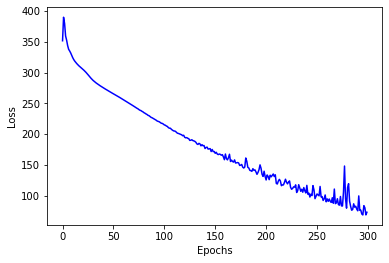

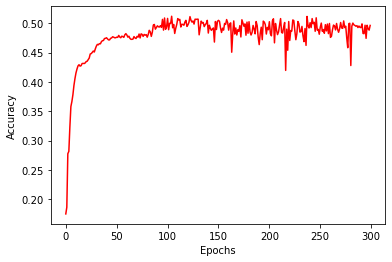

In [12]:
# 900 must -> image size, 6 must -> classification size, add number between 900 and 6 -> like [900, 150, 6]
object1 = CNN(layer_dims=[900,300,125, 6], num_epoch=300, learning_rate=0.02, last_layer_act_func="sigmoid", batch_size=64)
# I already converted input images to numpy array
object1.read_train("C:/Users/MehmetTahaUSTA/archive/seg_train/seg_train") # 1 time enough
object1.read_train("C:/Users/MehmetTahaUSTA/archive/seg_test/seg_test", modelname="validation") # 1 time enough
object1.load_train("train")
object1.load_train("validation")
object1.init_parameter()
object1.train()
object1.save_models()

## 4 Implementation

 optimal hidden layer number is 2.

object1 = CNN(layer_dims=[900,300,125, 6], num_epoch=300, learning_rate=0.02, last_layer_act_func="sigmoid", batch_size=64)

 optimal batch size is 64.

 optimal learning rate 0.002.

 activations functions: Sigmoid and Relu

 loss functions: negative log-likelihood

## 5 Analysis

High initial weight values cause low accuracy. hence the number of epoch must be large

algorithm misclassified -> insufficient test and train data

In general, it is not beneficial to set up a neural network with too many layers.

Insufficient mixing of train data in itself affects accuracy

Softmax is unstable function. Sigmoid gives more accurate results.

Because the train is insufficient, the model is overfitted after a certain period of time.

Increasing computing load with increasing number of layers and nodes

Relu more computationally efficient to compute than Sigmoid like functions since Relu just needs to pick max(0, x) and not perform expensive exponential operations as in Sigmoids

Relu tend to show better convergence performance than sigmoid.

CNN gives more accurate results than naive bayes and KNN.

If my learning rate is set too low, training will progress very slowly as you are making very tiny updates to the weights in your network. However, if my learning rate is set too high, it can cause undesirable divergent behavior in your loss function.